# Milestone Final notebook 
<p> In this notebook we have compiled most of our work towards the final milestone. Note that it might not contain everything we have done as some of our work has been not conclusive enough to be featured in this notebook. Therefore if you want a complete look at all computation and all graph you can look in the corresponding network for each topic.
    
This notebook provides an overview about our project and the computations that led to our report.

To have a better understanding about our thought process you can look into the <a href="./README.md"> README file </a> which contains more information. 

Finally you can also read the reports which synthesize our work.

 
    
</p>

In [75]:
import pandas as pd
import numpy as np
import scipy as scp
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import seaborn as sns # for visualization
import networkx as nx
import geopy as gp
from geopy import distance

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from numpy.linalg import norm

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K


In [76]:
DATAPATH='data/'

In [77]:
data = pd.read_csv(DATAPATH+'openfoodfacts.csv',delimiter='\t',low_memory=False)

In [78]:
print(data.shape)
print(data["code"].value_counts().count()) 
print(data["manufacturing_places_tags"].value_counts().count()) 
print(data["manufacturing_places"].value_counts().count()) 
print(data["categories"].value_counts().count())
print(data["origins_tags"].value_counts().count()) 

data.head()

(681602, 173)
681533
11731
12884
62746
6606


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1523440823,2018-04-11T10:00:23Z,Salade de carottes râpées,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
#fasters than pd.Series.corr(...)
def correlation_columns(column1,column2,dataset=data):
    matrix=dataset[[column1,column2]].dropna().values
    return scp.stats.spearmanr(matrix[:,0],matrix[:,1])

In [80]:
#example of use of the correlation function
print(correlation_columns('energy-from-fat_100g','fat_100g'))
print(correlation_columns('energy_100g','fat_100g'))
print(correlation_columns('energy_100g','energy-from-fat_100g'))
print(correlation_columns('energy_100g','salt_100g'))
print(correlation_columns('salt_100g','fat_100g'))

SpearmanrResult(correlation=0.9541993534189801, pvalue=0.0)
SpearmanrResult(correlation=0.7271139468364123, pvalue=0.0)
SpearmanrResult(correlation=0.7540616023088049, pvalue=5.9775818268021775e-168)
SpearmanrResult(correlation=0.11703649997107275, pvalue=0.0)
SpearmanrResult(correlation=0.333045389921474, pvalue=0.0)


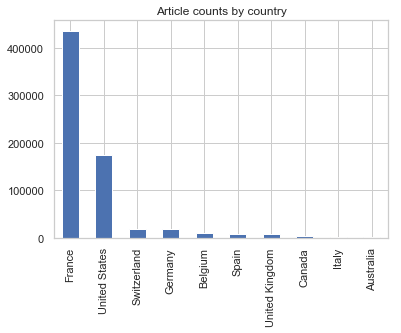

In [81]:
# Let us examine the selling countries of the articles.
data.set_index('code',inplace=True)
countries_cnt = data[["countries_en"]]
flatmap_c = countries_cnt["countries_en"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()

flatmap_c.columns = ["countries_en"]
flatmap_c = flatmap_c.reset_index().set_index("code")
flatmap_c = flatmap_c[["countries_en"]]
flatmap_c = flatmap_c["countries_en"].value_counts()
# only take the ten most significant. 
top_ten = flatmap_c[flatmap_c > 5].nlargest(10)
top_ten.plot.bar(color='b')
plt.title("Article counts by country")
plt.show()
data.reset_index(inplace=True)

The majority of the product entered in the database were sold in France or in the United States. Neverthelss, a quick view shows that the product from the United States have very poor informaiton provided. 

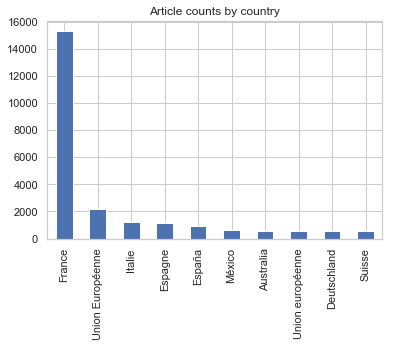

In [82]:
# Let us examine the origin of the articles.
data.set_index('code',inplace=True)
origin_cnt = data[["origins"]]
flatmap = origin_cnt["origins"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()

flatmap.columns = ["origins"]
flatmap = flatmap.reset_index().set_index("code")
flatmap = flatmap[["origins"]]
flatmap = flatmap["origins"].value_counts()
# only take the ten most significant. 
top_ten = flatmap[flatmap > 5].nlargest(10)
top_ten.plot.bar(color='b')
flatmap_all = flatmap # to be used later. 
plt.title("Article counts by country")
plt.show()
data.reset_index(inplace=True)

- We can see most of our articles come from France this must be kept in mind when we work on our project ! 

# Get rid of dupplicates

<p> We will use the code as unique index. However some articles dont have codes. Hence we use dummy codes that are not taken yet in order to get a nice unique index. </p>

In [83]:
# Check values thave haveno code value. 
null_code = data[pd.isnull(data['code'])].shape[0]
print(null_code)
start_dummy_code = 10000000000000
end_dummy_code = 10000000000000+null_code
dummy_code = list(range(start_dummy_code,end_dummy_code+1))


for i,row in enumerate(data[pd.isnull(data['code'])].index):
    data.loc[[row],['code']] = dummy_code[i]


34


In [84]:
# investigate duplicates. 
data[data.duplicated(subset=['code'],keep=False)]

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
71442,0055577102152,http://world-en.openfoodfacts.org/product/0055...,openfoodfacts-contributors,1539826478,2018-10-18T01:34:38Z,1539976159,2018-10-19T19:09:19Z,Gruau rapide /Quick Oats,NaN,350 g 12 sachets / packets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71443,0055577102152,http://world-en.openfoodfacts.org/product/0055...,openfoodfacts-contributors,1539826478,2018-10-18T01:34:38Z,1539976159,2018-10-19T19:09:19Z,Gruau rapide /Quick Oats,NaN,350 g 12 sachets / packets,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101556,0076677541078,http://world-en.openfoodfacts.org/product/0076...,openfoodfacts-contributors,1540244391,2018-10-22T21:39:51Z,1540288056,2018-10-23T09:47:36Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101557,0076677541078,http://world-en.openfoodfacts.org/product/0076...,openfoodfacts-contributors,1540244391,2018-10-22T21:39:51Z,1540288056,2018-10-23T09:47:36Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122496,010430652874676217,http://world-en.openfoodfacts.org/product/0104...,twoflower,1539339164,2018-10-12T10:12:44Z,1539340512,2018-10-12T10:35:12Z,"Hackfleisch vom Rind und Schwein gemischt, zum...",NaN,300 g,...,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122497,010430652874676217,http://world-en.openfoodfacts.org/product/0104...,twoflower,1539339164,2018-10-12T10:12:44Z,1539340512,2018-10-12T10:35:12Z,"Hackfleisch vom Rind und Schwein gemischt, zum...",NaN,300 g,...,NaN,11.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125670,0201117045599,http://world-en.openfoodfacts.org/product/0201...,kiliweb,1527589731,2018-05-29T10:28:51Z,1540291410,2018-10-23T10:43:30Z,Tarte aux Fraises 4/6 personnes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125671,0201117045599,http://world-en.openfoodfacts.org/product/0201...,kiliweb,1527589731,2018-05-29T10:28:51Z,1540291410,2018-10-23T10:43:30Z,Tarte aux Fraises 4/6 personnes,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147454,0638097545939,http://world-en.openfoodfacts.org/product/0638...,openfoodfacts-contributors,1536958002,2018-09-14T20:46:42Z,1537028604,2018-09-15T16:23:24Z,the vert Grey detox,NaN,100g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147455,0638097545939,http://world-en.openfoodfacts.org/product/0638...,openfoodfacts-contributors,1536958002,2018-09-14T20:46:42Z,1537028604,2018-09-15T16:23:24Z,the vert Grey detox,NaN,100g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- We see that the duplicated data can be dropped safely as they are just articles that have been entered twice, and we can then set our index...

In [85]:
# Drop duplicates, set index, and check if ok. 
data = data.drop_duplicates(subset=['code'],keep="first")
data.set_index('code',inplace=True)
data.index.is_unique

True

<p> We now have unique index and we can save the file </p>

In [86]:
data.to_csv(DATAPATH+"/cleaned_unique_index.csv")

## Data preparation for the different tasks

#### Data for distance computation

In [87]:
b = ~data["origins_tags"].isnull()
c = ~data["manufacturing_places_tags"].isnull()

sele = b|c  # 80270

data_loc = data[sele] # 80270 (au lieu 88001si packaging geo pris en compte)
print(data_loc.shape)

col = ['categories_en', 'main_category_en', 'labels_en', 'origins_tags', 'manufacturing_places_tags', 
       'first_packaging_code_geo', 'countries_en']

data_loc = data_loc[col]
data_loc.to_csv(DATAPATH+'food_origins.csv')

(80270, 172)


#### Data for palm computation
<p> We are interested in isolating information about palm oil. </p>

In [13]:
palm_oil = []
for col in data.columns:
    ## keep columns that have info about palm oil.. 
    if ("palm_oil") in col:
        palm_oil.append(col)

# Drop rows that have absolutely no information about palm_oil.         
palm_oil_data = data.dropna(how='all',subset=palm_oil)[palm_oil]
palm_oil_data.head()

,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags
code,,,,,,
0000000001199,0.0,NaN,NaN,0.0,NaN,NaN
0000000001663,0.0,NaN,NaN,0.0,NaN,NaN
0000000002264,0.0,NaN,NaN,0.0,NaN,NaN
0000000003827,0.0,NaN,NaN,0.0,NaN,NaN
0000000004510,0.0,NaN,NaN,0.0,NaN,NaN


In [14]:
palm_oil_data.to_csv(DATAPATH+'palm_oil.csv',columns=palm_oil_data.columns,index=True)

#### Data for labels

In [15]:
labels =[]
for col in data.columns:
    #isolate columns with info about labels. 
    if ("labels") in (col):
        labels.append(col)
print("Columns for label : " + str(labels))

# drop articles with no info about labels.
labels_data = data.dropna(how='all',subset=labels)[labels]
labels_data.head()


Columns for label : ['labels', 'labels_tags', 'labels_en']


,labels,labels_tags,labels_en
code,,,
0000000020114,Fabriqué en France,en:made-in-france,Made in France
0000000274722,"Viande Française,Fabriqué en France","fr:viande-francaise,en:made-in-france","fr:Viande Française,Made in France"
0000003444009,Contient des OGM,en:contains-gmos,Contains GMOs
0000005200016,AB,"en:organic,en:eu-organic,fr:ab-agriculture-bio...","Organic,EU Organic,fr:AB Agriculture Biologique"
0000007020254,"Kascher,Contient des OGM","en:kosher,en:contains-gmos","Kosher,Contains GMOs"


In [16]:
labels_data.to_csv(DATAPATH+'labels.csv',columns=labels_data.columns,index=True)

#### Data for vegan

In [17]:
data_=data.dropna(subset=['labels_tags'])
#keeping only vegan labelled data, removing the non-vegan or no-vegan labelled
vegan_data=data_[data_['labels_tags'].str.contains('vegan').fillna(False) & (~ data_['labels_tags'].str.contains('no-vegan').fillna(False)) ]
non_vegan_data=data_[(~ data_['labels_tags'].str.contains('vegan').fillna(False)) | data_['labels_tags'].str.contains('no-vegan').fillna(False) ]


In [18]:
vegan_data.to_csv(DATAPATH+'vegan.csv',columns=vegan_data.columns,index=True)

In [19]:
non_vegan_data.to_csv(DATAPATH+'non_vegan.csv',columns=vegan_data.columns,index=True)

In [20]:
print(vegan_data.size+non_vegan_data.size)
print(data_.size)
del data_


17232184
17232184


# 0) Distance Computation

A dictionary was made with the nouns given in countries_en. Typically in this column the nouns should be in english but sometimes it is not so all the nouns that indicate the same country have to be merge. To do so a disctionary was done (in another script). As the procedure is a bit long, the result is saved in a csv file which is load here.

In [88]:
dico = pd.read_csv('data/SeveralNamesOneCountry.csv',delimiter=',',low_memory=False)
dictionary_country = dict(zip(dico['destination'], dico['country']))
dictionary_country

{'France': 'France',
 'Spain': 'Spain',
 'Germany': 'Germany',
 'Switzerland': 'Switzerland',
 'United Kingdom': 'United Kingdom',
 'Belgium': 'Belgium',
 'Mexico': 'Mexico',
 'Australia': 'Australia',
 'United States': 'USA',
 'Italy': 'Italy',
 'Sweden': 'Sweden',
 'Canada': 'Canada',
 'Serbia': 'Serbia',
 'Portugal': 'Portugal',
 'Russia': 'Russia',
 'Romania': 'Romania',
 'Netherlands': 'Netherlands',
 'Austria': 'Austria',
 'Denmark': 'Denmark',
 'Réunion': 'France',
 'Hungary': 'Hungary',
 'Guadeloupe': 'Dom-tom',
 'Brazil': 'Brazil',
 'French Polynesia': 'Dom-tom',
 'Hong Kong': 'Hong Kong',
 'Poland': 'Poland',
 'Madagascar': 'Madagascar',
 'Ireland': 'Ireland',
 'Tunisia': 'Tunisia',
 'New Zealand': 'New Zealand',
 'India': 'India',
 'South Africa': 'RSA',
 'Luxembourg': 'Luxembourg',
 'French Guiana': 'Dom-tom',
 'Georgia': 'USA',
 'Deutschland': 'Germany',
 'Czech Republic': 'Czechia',
 'Morocco': 'Morocco',
 'Algeria': 'Algeria',
 'Martinique': 'Dom-tom',
 'Greece': 'Greece

To have a more meaningful result we separated Dom-tom and France. Basically the distance that a product travels to reach one of the Dom-tom's country or France is very differente and we think it should not be mixed. For instance if a product comes from Bresil, the distance until French Guiana will be very different to the one to reach France.

## Selling places of the products

In [89]:
z = data_loc["countries_en"].str.split(',').apply(pd.Series)
z1 = z.unstack().dropna()
z1 = z1.to_frame()
z1.columns = ['destination']

In [90]:
# Manual pre-processing : change destination with special characters
# manually checked on wikipedia + google maps
z1[z1['destination'] == 'Other-日本'] = 'Japon' # manually checked on wiki
z1[z1['destination'] == '中国'] = 'Chine'
z1[z1['destination'] == 'fr:香港'] = 'Hong Kong'
z1[z1['destination'] == 'fr:日本'] = 'Japon'
z1[z1['destination'] == 'Ελλάδα'] = 'Grèce'
z1[z1['destination'] == 'ar:صنعاء'] = 'Sanaa'
z1[z1['destination'] == 'fr:الجزائر'] = 'Algérie'


In [91]:
# remove fr: or others xx: in destination
def split_xx(l):
    tmp = l.split(':')
    
    if len(tmp) == 1:
        return l
    else:
        return tmp[1]
        
z1['destination'] = z1['destination'].apply(lambda l: split_xx(l))

In [92]:
# Remove illelevant information
print(z1.shape)
z1 = z1[~(z1 == 'Photos uploaded')]
z1 = z1[~(z1 == 'Photos validated')]
z1 = z1[~(z1 == 'Product name completed')]
z1 = z1[~(z1 == 'Photos to be uploaded')]
z1 = z1[~(z1 == 'Photos to be validated')]
z1 = z1[~(z1 == 'Quantity completed')]
z1 = z1[~(z1 == 'Nutrition facts completed')]
z1 = z1[~(z1 == 'Ingredients completed')]
z1 = z1[~(z1 == 'Brands completed')]
z1 = z1[~(z1 == 'Packaging completed')]
z1 = z1[~(z1 == 'Characteristics completed')]
z1 = z1[~(z1 == 'Categories completed')]
z1 = z1[~(z1 == 'Packaging-code-completed')]
z1 = z1[~(z1 == 'Expiration date completed')]
z1 = z1[~(z1 == 'Expiration date to be completed')]
z1 = z1[~(z1 == 'En')]
z1 = z1[~(z1 == 'To be completed')]
z1 = z1[~(z1 == 'To be checked')]
z1 = z1[~(z1 == 'Worldwide')]
z1 = z1[~(z1 == 'World')]
z1 = z1[~(z1 == 'Sucre')]
z1 = z1[~(z1 == 'Complete')]
z1 = z1[~(z1 == 'Global-market')]
z1 = z1[~(z1 == 'Dat')]
z1 = z1[~(z1 == 'France-others')]

z1 = z1.dropna()
print(z1.shape)

(89498, 1)
(88947, 1)


In [93]:
# Replace manually some values that did not work with geopy
z1[z1['destination'] == 'Leclerc-bois-d-arcy-france'] = 'France'
z1[z1['destination'] == 'Francecontient-des-sulfites'] = 'France'
z1[z1['destination'] == 'Leclerc'] = 'France'
z1[z1['destination'] == 'Auchan'] = 'France'
z1[z1['destination'] == 'Carrefour'] = 'France'
z1[z1['destination'] == 'Estadps-unidos'] = 'United States'
z1[z1['destination'] == 'Polyensie-francaise'] = 'French Polynesia'

In [94]:
z1['Arrival'] = z1['destination'].apply(lambda l: dictionary_country[l])

View where are the products from the database being sold

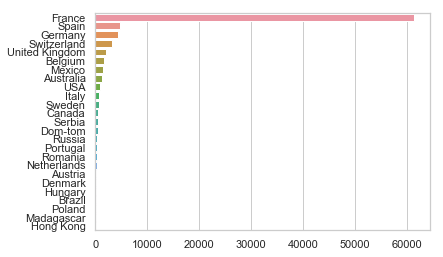

In [95]:
country_count = z1["Arrival"].value_counts()[0:25]

sns.set(style='whitegrid')
sns.barplot(y=country_count.index, x=country_count.values)

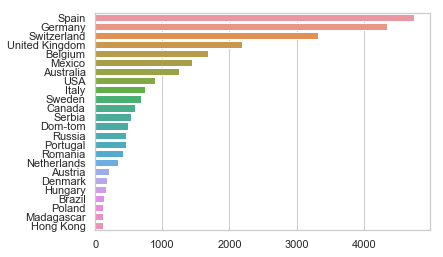

In [96]:
country_count = z1["Arrival"].value_counts()[1:25]

sns.set(style="whitegrid")
sns.barplot(y=country_count.index, x=country_count.values)

## Focus on french products

Select only the french products

In [97]:
z1 = z1.swaplevel()
z1 = z1.reset_index(level=1, drop=True)

In [98]:
selection = z1[z1['Arrival'] == 'France']
french_product = data_loc.loc[selection.index]
french_product.head()

,categories_en,main_category_en,labels_en,origins_tags,manufacturing_places_tags,first_packaging_code_geo,countries_en
code,,,,,,,
0000000020114,Dietary supplements,Dietary supplements,Made in France,NaN,france,NaN,France
0000000274722,"Meals,Meat-based products,Meals with meat,Poul...",Meals,"fr:Viande Française,Made in France",france,france,NaN,France
0000007020254,"Beverages,Carbonated drinks,Sodas,Sugared beve...",Beverages,"Kosher,Contains GMOs",NaN,etats-unis,NaN,"France,United States"
0000007730009,"Sugary snacks,Biscuits and cakes,Biscuits,Shor...",Sugary snacks,Green Dot,NaN,"france,avranches",NaN,France
0000009336247,"Sugary snacks,Confectioneries,Candies",Sugary snacks,"No artificial flavors,Contains GMOs",NaN,etats-unis,NaN,France


In [99]:
french_product.to_csv('data/FrenchProduct.csv')

In [100]:
# check
country_count = french_product["countries_en"].value_counts()[0:20]
country_count

France                        54880
France,Switzerland             1225
Belgium,France                  706
France,Germany                  630
France,Spain                    604
France,United Kingdom           596
France,Réunion                  216
France,Italy                    183
France,United States            156
France,Germany,Switzerland      119
France,Guadeloupe                92
Australia,France                 66
France,Netherlands               63
Canada,France                    61
France,French Polynesia          59
France,Portugal                  57
Belgium,France,Switzerland       57
France,French Guiana             51
Réunion                          49
France,En                        46
Name: countries_en, dtype: int64

# 1) Palm Oil

## Exploring the number of aliments that contain palm oil

In [21]:
total_count = data.shape[0]
palm_oil_count = palm_oil_data.shape[0]
percentage = palm_oil_count / total_count * 100

print("We have a total of %d articles entered" % total_count)
print("Out of those we have information about palm oil on %d articles " % palm_oil_count)
print("This represents %f %% " % percentage)

We have a total of 665693 articles entered
Out of those we have information about palm oil on 387961 articles 
This represents 58.279267 % 


- While this amount seems a bit low it is still more than half articles. We remove from our study all articles that we do not have information about as they could make future analysis biased. The sample of size 387964 is still a fairly large sample size that we can make some statistical analysis on

In [22]:
palm_oil_data.head()

,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags
code,,,,,,
0000000001199,0.0,NaN,NaN,0.0,NaN,NaN
0000000001663,0.0,NaN,NaN,0.0,NaN,NaN
0000000002264,0.0,NaN,NaN,0.0,NaN,NaN
0000000003827,0.0,NaN,NaN,0.0,NaN,NaN
0000000004510,0.0,NaN,NaN,0.0,NaN,NaN


In [23]:
contains_palm = palm_oil_data[palm_oil_data['ingredients_from_palm_oil_n'] > 0.0]
may_contain_palm = palm_oil_data[palm_oil_data['ingredients_that_may_be_from_palm_oil_n'] > 0.0]
contains_palm['count'] = 1
may_contain_palm['count'] = 1

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
contains_palm.index.difference(may_contain_palm.index)
# This can be useful to see that there is some correlation between may_contain <->contains

Index(['0000000290616', '0000069006562', '00023092', '00035460', '00052283',
       '00087728', '00088749', '00096225', '00099202', '00101356',
       ...
       '9556085735739', '9556121020164', '9556417639339', '9556439887497',
       '9556587103869', '96121283', '9714176130355', '98152056', '98797554',
       '99515874'],
      dtype='object', name='code', length=8229)

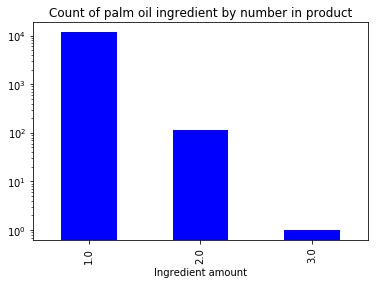

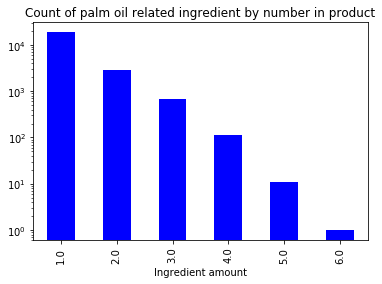

In [25]:
## Group by how many ingredients contain palm oil. and may contain. 
count_palm = contains_palm.groupby("ingredients_from_palm_oil_n")['count'].count()
count_may = may_contain_palm.groupby("ingredients_that_may_be_from_palm_oil_n")['count'].count()
count_palm.plot.bar(logy=True,title="Count of palm oil ingredient by number in product",color='b')
plt.xlabel("Ingredient amount")
plt.show()
count_may.plot.bar(logy=True,title="Count of palm oil related ingredient by number in product",color='b')
plt.xlabel("Ingredient amount")
plt.show()

- We can see that that most of the product seem to have only one ingredient or two that are related to palm oil
- However the product that may contains palm oil can have a little more ingredients. 

There is 11768 articles that contain palm oil.
There is 22433 articles that may contain palm oil 
The correlation between food that contains palm oil and that may contains palm oil is 0.193331 


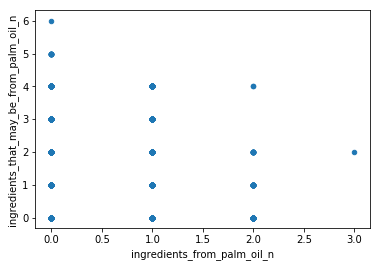

In [26]:
## One can wonder how much this represents in terms of relations. 
cnt_palm = contains_palm.shape[0] 
may_cnt_palm = may_contain_palm.shape[0]
print("There is %d articles that contain palm oil."%cnt_palm)
print("There is %d articles that may contain palm oil "%may_cnt_palm)
correlation = data["ingredients_from_palm_oil_n"].corr(data["ingredients_that_may_be_from_palm_oil_n"],method="pearson")
print("The correlation between food that contains palm oil and that may contains palm oil is %f " % correlation)

data.plot.scatter(x="ingredients_from_palm_oil_n",y="ingredients_that_may_be_from_palm_oil_n")
plt.show()

<p> We can't infer much as the scatter plots are not very helpful in visualize the data. Nut we can see that the correlation is low (less than 0.2) so there is not much relation between the number of ingredients and how many may contain palm oil.  </p>

### Origin of the palm oil food 

In [27]:
food_origin = pd.read_csv(DATAPATH+"food_origins.csv")
food_origin.set_index("code", inplace=True)
food_origin.head()

,origins_tags,origins_tags.1,manufacturing_places_tags
code,,,
0000000020114,NaN,NaN,france
0000000274722,france,france,france
0000000290616,quebec,quebec,brossard-quebec
0000000394710,quebec,quebec,brossard-quebec
0000001071894,france,france,united-kingdom


In [28]:
# Let us see first how much data we have available..
contains_palm.join(food_origin).shape[0], contains_palm.shape[0],food_origin.shape[0]

(11768, 11768, 86142)

In [29]:
## these operations are done to map the origin and do a value count on the origin..
joined = contains_palm.join(data["origins"],how='inner').dropna(subset=["origins"])
# this simulates flatmap ( explode from spark ) 
flatmap = joined["origins"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()

flatmap.columns = ["origins"]
flatmap = flatmap.reset_index().set_index("code")
flatmap = flatmap[["origins"]]
flatmap = flatmap["origins"].value_counts()
# only take the ten most significant. 
top_ten = flatmap[flatmap > 5].nlargest(10)

- We notice that a lot of places seem to be from france. But we cant really see the trend as it is often in a bad format.

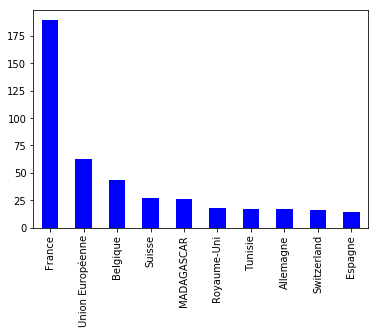

In [30]:
top_ten.plot.bar(color='b')

- Note that this is not 100% representative as the database is french so there are more products that come from France that are logged. 


#### Now we work on standarization of values..

To standardize a parameter $p$ we need to compute the ratio $r$ of a given country $x$. We do : 
\begin{equation}
r = \frac{x_{count\_p}}{x_{count\_total}} \\
x_{count\_total} = \sum_{a \in articles} a_{origin} = x\\
x_{count\_p}  = \sum_{a \in articles} a_{origin} = x \land a_p = p 
\end{equation}


In [31]:
## precomputation..
flatmap = flatmap.to_frame()
flatmap.columns = ["count"]

flatmap_all = flatmap_all.to_frame()
flatmap_all.columns = ["count"]

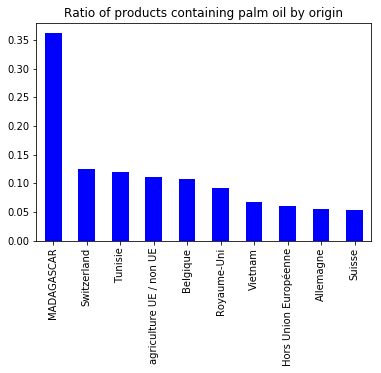

In [32]:
# join the two dataset and compute a ratio value. 
stand = flatmap.join(flatmap_all, lsuffix = "_palm", rsuffix ="_total")
stand["ratio"] = stand["count_palm"]/stand["count_total"]


stand_best = stand[stand["count_palm"] > 10].nlargest(10,"ratio")
stand_best["ratio"].plot.bar(color='b')
plt.title("Ratio of products containing palm oil by origin")
plt.show()

- After standardizing the values by how many articles from each origin, we can note that the major countries producing values containing palm oil are madagascar and switzerland. 

## Categories of aliment. 

we now investigate what time of aliments are more likely to contain palm oil. This can help future shoppers to be more wary around these type of articles and also helps us understand where the need for palm oil is the biggest.

In [33]:
join_categories = palm_oil_data.join(data["main_category_en"],how="inner").dropna(subset=["main_category_en"])
join_categories.head()

,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,main_category_en
code,,,,,,,
0000000005470,0.0,NaN,NaN,0.0,NaN,NaN,Plant-based foods and beverages
0000000020114,0.0,NaN,NaN,0.0,NaN,NaN,Dietary supplements
0000000274722,0.0,NaN,NaN,0.0,NaN,NaN,Meals
0000000290616,1.0,NaN,huile-de-palme,0.0,NaN,NaN,Plant-based foods and beverages
0000000394710,0.0,NaN,NaN,1.0,NaN,huile-vegetale,Sugary snacks


- Unfortunately this subset is a bit to small to work with.. let us try to expand to all categories. 

In [34]:
categories_contains = contains_palm.join(data["categories"],how="inner").dropna(subset=["categories"])
categories_may_contain = may_contain_palm.join(data["categories"],how="inner").dropna(subset=["categories"])

In [35]:
categories_may_contain.head()

,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,count,categories
code,,,,,,,,
0000000394710,0.0,NaN,NaN,1.0,NaN,huile-vegetale,1,"Snacks sucrés,Biscuits et gâteaux,Pâtisseries"
0000008237798,0.0,NaN,NaN,1.0,NaN,huile-vegetale,1,Quiches lorraines
0000010206515,1.0,NaN,huile-de-palme,1.0,NaN,e471-mono-et-diglycerides-d-acides-gras-alimen...,1,"Pâtes à sucre,Décorations,fr:Confiseries"
0000040144078,0.0,NaN,NaN,1.0,NaN,huile-vegetale,1,"Snacks sucrés,Confiseries,Confiseries chocolat..."
0000069160028,0.0,NaN,NaN,1.0,NaN,e471-mono-et-diglycerides-d-acides-gras-alimen...,1,Desserts glacés


In [36]:
categories_contains.head()

,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,count,categories
code,,,,,,,,
0000000290616,1.0,NaN,huile-de-palme,0.0,NaN,NaN,1,Légumes-feuilles
0000010206515,1.0,NaN,huile-de-palme,1.0,NaN,e471-mono-et-diglycerides-d-acides-gras-alimen...,1,"Pâtes à sucre,Décorations,fr:Confiseries"
0000069006562,1.0,NaN,huile-de-palme,0.0,NaN,NaN,1,"Surgelés,Rostis,Plats préparés surgelés"
00023092,1.0,NaN,huile-de-palme,0.0,NaN,NaN,1,"Cookies,Cookies aux noix de pécan"
00027083,1.0,NaN,huile-de-palme,3.0,NaN,"e481-stearoyl-2-lactylate-de-sodium,e472e-este...",1,Muffins à la myrtille


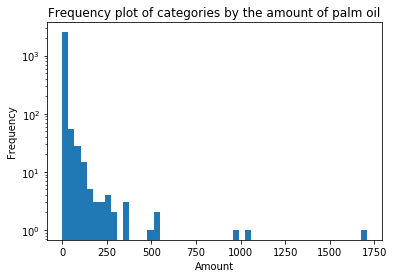

In [37]:
abc = categories_contains["categories"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()#.reset_index().set_index("code").groupby("0")
abc.columns = ["categories"]
hi = abc.reset_index().set_index("code")["categories"].value_counts()
hi.plot.hist(bins=50,logy=True,title="Frequency plot of categories by the amount of palm oil")
plt.xlabel("Amount")
plt.show()

- One might wonder what are the biggest categories in term of palm oil consumption !

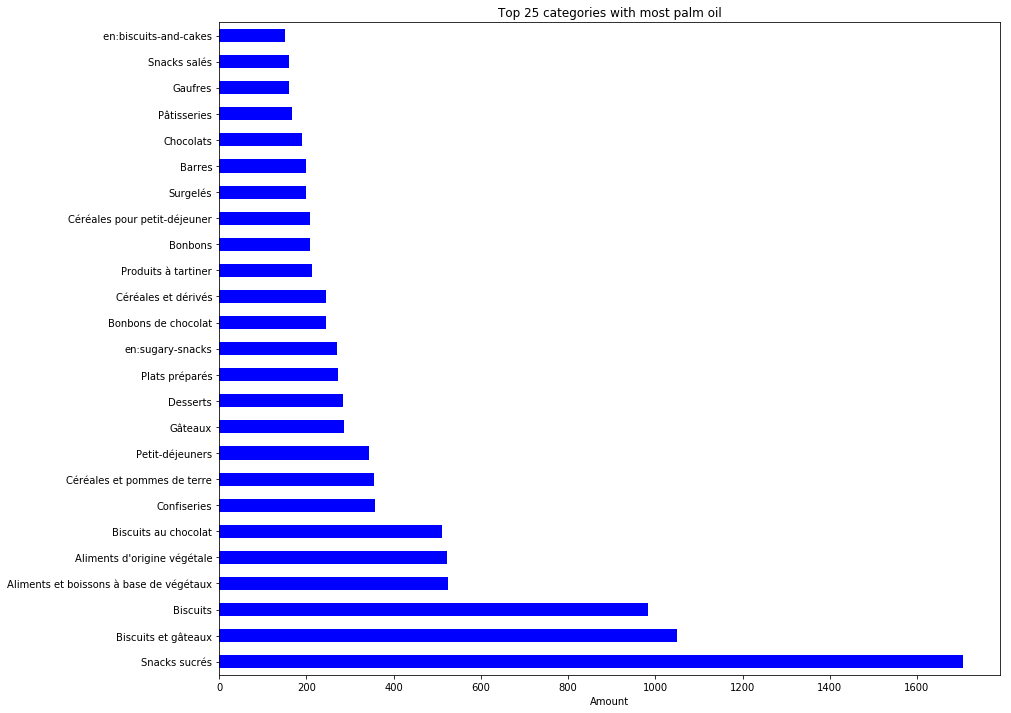

In [38]:
hi.nlargest(25).plot.barh(figsize=(14,12),color='b',title="Top 25 categories with most palm oil")
plt.xlabel("Amount")
plt.show()

- From this analysis we can see that most products that contain palm oil seem to be sweets and cookie derivated products. So if you want to help the Amazon you should be extra careful around sweet snacks. 

## Timeline of palm oil

- Now we want to investigate the tendency over time of products containing palm oil. If there is more or less of them over time. To do this we will refer to the first time they were added to the database, and see if more products that contain palm oil have been added lately. 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


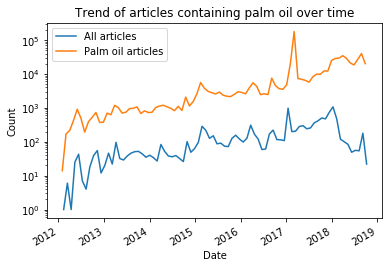

In [39]:
data["created_datetime"] = pd.to_datetime(data["created_datetime"],errors="coerce")
dateparsed = data[data["created_datetime"].notnull()]

### we create a dataset and then count by date. 
palm_dated = contains_palm.join(dateparsed["created_datetime"],how='inner')
palm_dated = palm_dated[["created_datetime"]].reset_index().set_index("created_datetime")#["code"].value_counts().to_frame()
palm_dated["count"] = 1

## resample to have 30days period. 
palm_dated = palm_dated["count"].resample("30D").sum()
palm_dated.plot.line(title="Trend of articles containing palm oil over time",logy=True)


## we also plot all articles to see the tendance in general. 
total_dated = dateparsed[["created_datetime"]].reset_index().set_index("created_datetime")
total_dated["count"] = 1
total_dated = total_dated["count"].resample("30D").sum()
total_dated.plot.line(logy=True)

plt.legend(["All articles","Palm oil articles"])
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

<p> We can see there are a few spikes that are explained as a user entering many different types of articles. Therefore there are not very statistically interesting. </p>

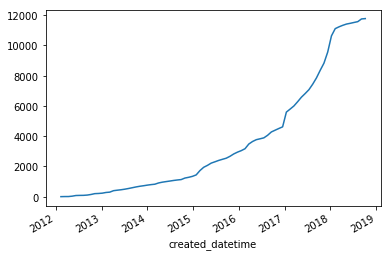

In [40]:
palm_dated.cumsum().plot.line()

<p> Here we notice a trend that is quadratic. So there seems to be more and more articles containing palm oil. </p>

# 2) Vegan

In [42]:
vegan_data.head()
origin_lists=vegan_data.origins_tags.dropna().str.split(',')
origin_exploded=origin_lists.apply(pd.Series).unstack()
#origin_exploded=pd.read(DATAPATH + 'quick_translate_origins.csv')
del origin_lists

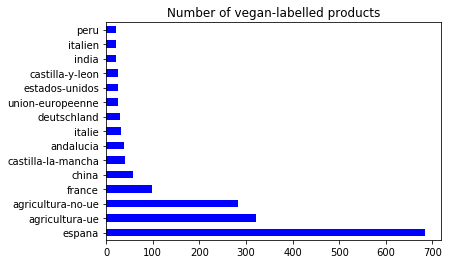

In [43]:
origin_exploded.value_counts().head(15).plot.barh(color='b')
plt.title('Number of vegan-labelled products')
plt.show()

In [44]:
total_origins=data.origins_tags.dropna().str.split(',')
total_origins_exploded=total_origins.apply(pd.Series).unstack()


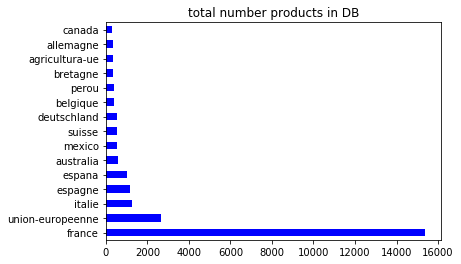

In [45]:
total_origins_exploded.value_counts().head()
total_origins_exploded.value_counts().head(15).plot.barh(color='b')
plt.title('total number products in DB')
plt.show()


<p>The bar chart above shows the bias of the data: way more data from france, and from european countries</p>

In [46]:
vegan_origin_df=origin_exploded.to_frame().reset_index().drop(labels=['level_0'],axis=1)
total_origin_df=total_origins_exploded.to_frame().reset_index().drop(labels=['level_0'],axis=1)

In [47]:
total_origin_df.columns=['level_1','origin']
total_origin_df=total_origin_df.dropna()
total_count=total_origin_df.groupby(by=['origin']).size().sort_values(ascending=False).to_frame()
vegan_origin_df.columns=['level_1', 'vegan_loc']
vegan_count=vegan_origin_df.groupby(by=['vegan_loc']).size().to_frame()
comparison=pd.merge(total_count,vegan_count,right_index=True,left_index=True,how='inner')


## Comment on data

The origins_tags series is messy.

First of all, same country entries are in different languange. The first approach is to deal with similar strings clustering: put together italy, italia and italien, but it would not work for austria osterreich as well as Germany Allemagne and Republica Federale Tedesca.

Another problem is the bias of the data base: it is a french data base, so will have more entries and more details for product from France, and frome Europe in a lower extend. To overcome that problem, we want to compare countries by their relative vegan production (vegan labelled production from one origin_tag over total production from the same).

But this solution shows a third problem: irrelevent tags. Some tags are to precise: regions or province, or even wrong ('soja' is not a country). For these tags are very rare, it is possible to have a confidence (the ratio that we talked about) of 100%: for instance, there is only one product tagged 'zamora-provincia' and this product is also tagged vegan, then 'zamora-provincia' will be the "vegan champion", but this is irrelevant to compare a precise province with entire country.

We addressed that last problem by thresholding the support (at 100 labbeled products), so we are sure to retrieve frequent countriews in the DB. Also we manually removed too general labelled because those can have a high support as well ('eu').

In [48]:
relevent_index=['aceitunas', 'afrique', 'agadir', 'agypten', 'alava', 'albacete-provincia', 'albatera', 'alemania', 'alicante', 'alicante-provincia', 'allemagne', 'almendras', 'almeria-provincia', 'almunecar', 'alps', 'amandes-d-italie', 'amazonas', 'amazonie', 'america-del-sur', 'amerique', 'amerique-centrale', 'amerique-du-nord', 'amerique-du-sud', 'andalucia', 'andes', 'angleterre', 'angleterre-betterave', 'aragon', 'aranjuez', 'argelia', 'argentina', 'argentinien', 'arroz', 'asie', 'asie-pour-le-fruit-de-moines', 'asturias', 'atlantico-suroeste', 'australia', 'austria', 'autol', 'autriche', 'avoine-francaise', 'azucar', 'azur-quelle', 'bajo-aragon', 'bali', 'batata', 'belgica', 'belgien', 'belgium', 'bolivia', 'bolivie', 'bolivien', 'bosnien-herzegowina', 'brazil', 'bresil', 'bretagne', 'burkina-faso', 'cacahuetes', 'cacao', 'caceres-provincia', 'cadiz-provincia', 'caldes-de-malavella', 'calera-y-chozas', 'california', 'californie', 'camargue', 'cambrils', 'cana-de-azucar', 'canada', 'casas-de-haro', 'castilla-la-mancha', 'castilla-y-leon', 'cataluna', 'cevennes', 'chile', 'china', 'chine', 'chufa', 'ciego-montero', 'cienfuegos', 'ciruelas', 'ciudad-real-provincia', 'col', 'col-lombarda', 'colombia', 'columbia', 'commerce-equitable', 'comunidad-valenciana', 'conil-de-la-frontera', 'cordoba-provincia', 'corea', 'costa-de-galicia', 'costa-de-marfil', 'costa-rica', 'cuba', 'cuenca-provincia', 'desconocido', 'deutschland', 'dominikanische-republik', 'e-u-a', 'ecuador', 'egipto', 'egnil', 'egypte', 'el-bolson', 'el-mirador', 'equateur', 'esmeraldas', 'espagne', 'espana', 'estados-unidos', 'etats-unis','eutschland', 'extremadura', 'filderstadt', 'filipinas', 'fontanilles', 'fougerolles', 'france', 'francia', 'frankreich', 'fresas', 'fuera-de-espana', 'galicia', 'gard', 'garray', 'germany', 'gerona-provincia', 'gers', 'gers-en-france-pour-le-ble', 'ghana', 'girona', 'golfo-de-vizcaya', 'granada-provincia', 'grece', 'grecia', 'greece', 'griechenland', 'guadalajara-provincia', 'haiti', 'haute-provence', 'herefordshire', 'holanda', 'hongrie','huelva-provincia', 'inde', 'india', 'indien', 'indien-landwirtschaft', 'indonesia', 'indonesie', 'indonesien', 'industria-argentina', 'ingrediente-s', 'iran', 'ireland', 'islas-canarias', 'israel', 'italia', 'italie', 'italien', 'italy', 'jaen', 'japon', 'jativa', 'kanada', 'kenia', 'kirgistan', 'kolumbien', 'la-coruna-provincia', 'la-mancha-comarca', 'la-manchuela-comarca', 'la-montiela-pedania', 'la-orotava', 'la-rioja', 'leimuiden', 'leinfelden-echterdingen', 'lerida-provincia', 'lombardia', 'lomellina', 'madagascar', 'madrid-comunidad-autonoma', 'malaga-provincia', 'malaui', 'manantial-amer-palatin', 'manantial-bezoya-de-trescasas', 'manantial-font-sacalm', 'manantial-fuente-primavera', 'manantial-fuentevera', 'manantial-siguenza', 'manantial-vichy-catalan', 'marinaleda', 'marruecos', 'mazarron', 'melocotones', 'mexico', 'mexiko', 'mexique', 'midlands-de-l-ouest', 'milano', 'minglanilla', 'minho-lima', 'modena', 'montricoux', 'montseny', 'moratilla-de-henares', 'motril', 'munchsteinach', 'murcia', 'murcia-comunidad-autonoma', 'mures-des-pays-bas', 'myrtilles-du-maroc', 'nao-ue', 'nardo', 'navarra', 'niederosterreich', 'niger', 'nijar','nueva-zelanda', 'osterreich', 'pais-vasco', 'pakistan', 'palmira', 'papua-neuguinea', 'paraguay', 'pavia-provincia', 'pays-bas', 'pepinillos', 'perou', 'peru', 'philippinen', 'philippines', 'pichincha-provincia', 'piemont', 'pioz', 'plano-tx', 'poland', 'polonia', 'portugal', 'quintanar-del-rey', 'regiao-do-norte', 'region-centro-norte', 'reino-unido', 'remolacha-y-zanahoria', 'republica-dominicana', 'republique-dominicaine', 'requena', 'requena-utiel-comarca', 'rheinland', 'ribera-del-jalon-comarca', 'rice', 'rio-negro', 'riz', 'romania', 'roumanie', 'royaume-uni', 'rugen', 'rumanien', 'salamanca-provincia', 'san-antonio-requena', 'sant-hilari-sacalm', 'santa-cruz-de-tenerife-provincia', 'santaella', 'santo-domingo', 'santo-tome-y-principe', 'sao-tome', 'sao-tome-und-principe', 'schweden', 'segovia-provincia', 'selva-comarca', 'serbia', 'sevilla-provincia', 'sicile', 'sierra-de-gredos', 'siguenza', 'slowakei', 'soja', 'soja-bio', 'soja-de-france', 'soja-de-francia', 'soja-europeen', 'soja-origine-france', 'soja-sud-est', 'soria-provincia', 'south-africa', 'south-africa-local-and-imported', 'spain', 'spanien', 'sri-lanka', 'sud-est-de-la-france', 'sud-ouest', 'sud-ouest-de-la-france', 'sudafrica', 'sudafrika', 'sudamerica', 'sudamerika', 'suisse', 'switzerland', 'tailandia', 'tanzania', 'tanzanie', 'tarn-et-garonne', 'tarragona-provincia', 'thailand', 'thailande', 'toledo-provincia', 'tomates', 'tozeur', 'trentino-alto-adigio', 'trescasas', 'trinidad', 'trinidad-und-tobago', 'tunesien', 'tunez', 'tunisia', 'tunisie', 'turkei', 'turquia', 'turquie', 'uca', 'ucrania', 'ue', 'ue-non-ue', 'uganda', 'ukraine',  'united-kingdom', 'united-states', 'united-states-of-america', 'usa', 'usa-and-other-unspecified-countries', 'val-venosta', 'valencia', 'valencia-provincia', 'valladolid-provincia', 'vancouver-bc', 'various', 'venezie', 'venezuela', 'verin', 'viana-do-castelo', 'viana-do-castelo-distrito', 'vietnam', 'villa-del-prado', 'villalgordo-del-jucar', 'villamalea', 'villanueva-de-la-jara', 'waldviertel', 'west-indies', 'wiesbaum', 'yuca', 'zamora-provincia', 'zaragoza-provincia' ] 
relevent_comparison=comparison.loc[relevent_index]
relevent_comparison=relevent_comparison[relevent_comparison['0_x']>100]
del relevent_index

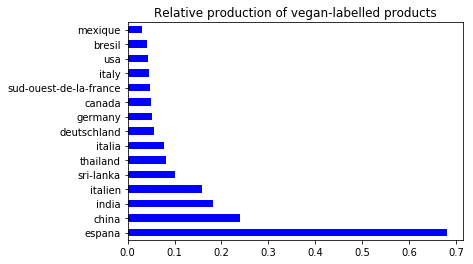

In [49]:
relevent_comparison['ratio']=relevent_comparison['0_y']/relevent_comparison['0_x']
relevent_comparison.ratio.sort_values(ascending=False).head(15).plot.barh(color='b')
plt.title('Relative production of vegan-labelled products')
plt.show()

## Comment on observations

Spain is the country that produce the higher part of vegan product relatively to its total production.

Let's check the categories of products coming from spain compared to production of the other leading countries. 



## Categories analysis

In [50]:
data__=data.dropna(subset=['origins_tags'])
data__.loc[:,'unique_origin']=''


D:\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [51]:
data__.loc[data__.origins_tags.str.contains('espana'),'unique_origin']='espana'
data__.loc[data__.origins_tags.str.contains('italien'),'unique_origin']='italien'
data__.loc[data__.origins_tags.str.contains('china'),'unique_origin']='china'
data__.loc[data__.origins_tags.str.contains('india'),'unique_origin']='india'
data__.loc[data__.origins_tags.str.contains('sri-lanka'),'unique_origin']='sri-lanka'

In [52]:
data__=data__[data__['unique_origin']!='']
data__.unique_origin.unique()

array(['china', 'sri-lanka', 'india', 'italien', 'espana'], dtype=object)

In [53]:
to_plot=data__.groupby(by=['unique_origin','main_category_en'])['unique_origin'].count()
del data__


In [54]:
data__=vegan_data.dropna(subset=['origins_tags'])
data__.loc[:,'unique_origin']=''
data__.loc[data__.origins_tags.str.contains('espana'),'unique_origin']='espana'
data__.loc[data__.origins_tags.str.contains('italien'),'unique_origin']='italien'
data__.loc[data__.origins_tags.str.contains('china'),'unique_origin']='china'
data__.loc[data__.origins_tags.str.contains('india'),'unique_origin']='india'
data__.loc[data__.origins_tags.str.contains('sri-lanka'),'unique_origin']='sri-lanka'
data__=data__[data__['unique_origin']!='']
data__.unique_origin.unique()
vegan_to_plot=data__.groupby(by=['unique_origin','main_category_en'])['unique_origin'].count()
del data__

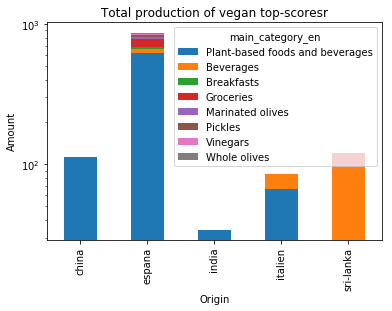

In [55]:
#threshold is here in order not be ugly with too many labels
to_plot[to_plot>15].unstack('main_category_en').fillna(0).plot(kind='bar',logy=True,stacked=True)
plt.title('Total production of vegan top-scoresr')
plt.ylabel('Amount')
plt.xlabel('Origin')
plt.savefig('stack_hist_total.png',bbox_inches='tight')
plt.show()

D:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:3370: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


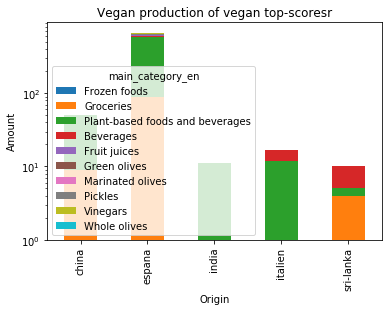

In [56]:
vegan_to_plot[to_plot>11].unstack('main_category_en').fillna(0).plot(kind='bar',logy=True,stacked=True)
plt.title('Vegan production of vegan top-scoresr')
plt.ylabel('Amount')
plt.xlabel('Origin')
plt.savefig('stack_hist_veeegan.png',bbox_inches='tight')
plt.show()

## Comment on observations

Both total and vegan production of plant-based food  and beverages represent the majority of spanish production. 



## Time evolution

In [57]:
vegan_data["created_datetime"] = pd.to_datetime(vegan_data["created_datetime"],errors="coerce")
dateparsed = vegan_data[vegan_data["created_datetime"].notnull()]
vegan_date=dateparsed.reset_index().set_index('created_datetime')

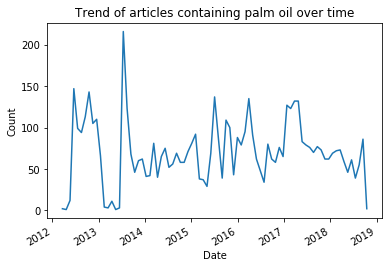

In [58]:
vegan_date["count"] = 1
vegan_date = vegan_date["count"].resample("30D").sum()
vegan_date.plot.line(title="Trend of articles containing palm oil over time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.show()

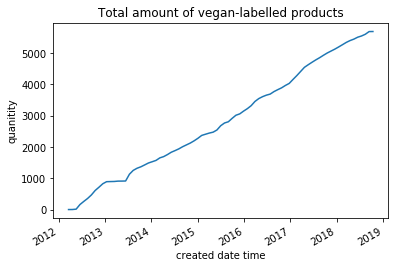

In [59]:
vegan_date.cumsum().plot.line()
plt.title('Total amount of vegan-labelled products')
plt.ylabel('quanitity')
plt.xlabel('created date time')

plt.savefig('vegan_evolution.png',bbox_inches='tight')

plt.show()

The total ammount of vegan products increases in a linear was, suggesting that the rate of vegan produced food is consant.

## Vegan products are less caloric

In [60]:
print(vegan_data['energy_100g'].dropna().describe())
print(non_vegan_data['energy_100g'].dropna().describe())

count    4659.000000
mean     1055.675694
std       860.834737
min         0.000000
25%       270.450000
50%       839.000000
75%      1653.000000
max      4402.000000
Name: energy_100g, dtype: float64
count    8.359900e+04
mean     1.149885e+03
std      6.526818e+03
min      0.000000e+00
25%      4.080000e+02
50%      1.046000e+03
75%      1.640000e+03
max      1.841546e+06
Name: energy_100g, dtype: float64


The description suggest that vegan products are less energetic than non-vegan ones. Let's try some statistic tests.

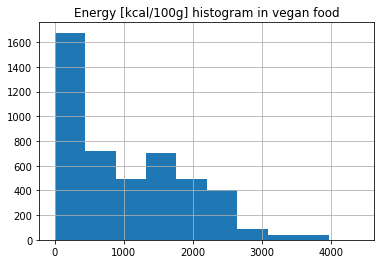

In [61]:
vegan_data['energy_100g'].dropna().hist()
plt.title('Energy [kcal/100g] histogram in vegan food')
plt.savefig('vegan_energy.png',bbox_inches='tight')
plt.show()

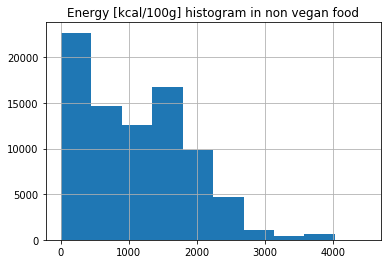

In [62]:
#discarding too high values
non_vegan_series=non_vegan_data['energy_100g'].dropna()
non_vegan_series[non_vegan_series<4500].hist()

plt.title('Energy [kcal/100g] histogram in non vegan food')
plt.savefig('non_vegan_energy.png',bbox_inches='tight')
plt.show()

the distributions are not normal, so we cannot run classical t-test to compare the different distribution

In [63]:
print("Vegan and non-vegan have same distribution: ")
print(scipy.stats.mannwhitneyu(vegan_data['energy_100g'].dropna(),non_vegan_series[non_vegan_series<4500],alternative='two-sided'))
print("\nVegan products are more energetic: ")
print(scipy.stats.mannwhitneyu(vegan_data['energy_100g'].dropna(),non_vegan_series[non_vegan_series<4500],alternative='less'))
print("\nNon-vegan products are more energetic: ")
print(scipy.stats.mannwhitneyu(vegan_data['energy_100g'].dropna(),non_vegan_series[non_vegan_series<4500],alternative='greater'))

Vegan and non-vegan have same distribution: 
MannwhitneyuResult(statistic=182530097.0, pvalue=9.599463470124489e-13)

Vegan products are more energetic: 
MannwhitneyuResult(statistic=182530097.0, pvalue=4.799731735062244e-13)

Non-vegan products are more energetic: 
MannwhitneyuResult(statistic=182530097.0, pvalue=0.99999999999952)


The Mann-Whitney U test, also known as Wilcoxon test, is non-parametric test based on ranks. The null-hypothesis is that the the two samples come from the same distribution. Here the p-value is quasi 0, so the null-hypothesis is rejected

This test can also be used to test wether the distribution of sample one will asymptotically come from a normal distribution with a higher mean than the other sample.

The hypothesis "Vegan products are more energetic" is rejected, hypothesis "non-vegan products are more energetic" since the p-value is almost 1.

## Vegan Label are less fat

In [64]:
print(vegan_data['fat_100g'].dropna().describe())
print(non_vegan_data['fat_100g'].dropna().describe())

count    4622.000000
mean       13.381840
std        18.963632
min         0.000000
25%         0.800000
50%         4.000000
75%        20.000000
max       102.000000
Name: fat_100g, dtype: float64
count    82627.000000
mean        13.546998
std         30.456529
min          0.000000
25%          1.000000
50%          6.100000
75%         21.000000
max       6500.000000
Name: fat_100g, dtype: float64


The description above also suggests that there is less fat in vegan product

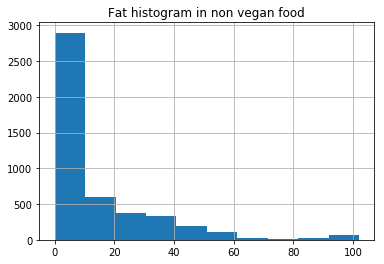

In [65]:
vegan_data['fat_100g'].dropna().hist()
plt.title('Fat histogram in non vegan food')
plt.savefig('vegan_fat.png',bbox_inches='tight')
plt.show()

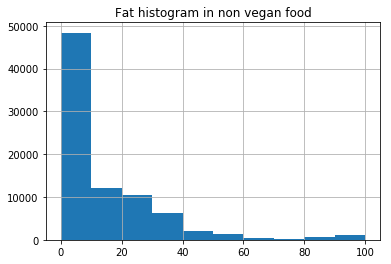

In [66]:
#removing outliers
non_vegan_series=non_vegan_data['fat_100g'].dropna()
non_vegan_series[non_vegan_series<120].hist()
plt.title('Fat histogram in non vegan food')
plt.savefig('non_vegan_fat.png',bbox_inches='tight')
plt.show()

In [67]:
print("Vegan and non-vegan have same distribution: ")
print(scipy.stats.mannwhitneyu(vegan_data['fat_100g'].dropna(),non_vegan_series[non_vegan_series<120],alternative='two-sided'))
print("\nVegan products are more fat: ")
print(scipy.stats.mannwhitneyu(vegan_data['fat_100g'].dropna(),non_vegan_series[non_vegan_series<120],alternative='less'))
print("\nNon-vegan products are more fat: ")
print(scipy.stats.mannwhitneyu(vegan_data['fat_100g'].dropna(),non_vegan_series[non_vegan_series<120],alternative='greater'))

Vegan and non-vegan have same distribution: 
MannwhitneyuResult(statistic=184114173.0, pvalue=4.5200481498045497e-05)

Vegan products are more fat: 
MannwhitneyuResult(statistic=184114173.0, pvalue=2.2600240749022748e-05)

Non-vegan products are more fat: 
MannwhitneyuResult(statistic=184114173.0, pvalue=0.9999773998176233)


In a similar way, the conclusion is that vegan product contain less fat, although the difference is less radical.

In [68]:
print("correlation between energy and fat in vegan data:")
print(correlation_columns('energy_100g','fat_100g',dataset=vegan_data))
print("\ncorrelation between energy and fat in non vegan data:")
print(correlation_columns('energy_100g','fat_100g',dataset=non_vegan_data))

correlation between energy and fat in vegan data:
SpearmanrResult(correlation=0.789358884812714, pvalue=0.0)

correlation between energy and fat in non vegan data:
SpearmanrResult(correlation=0.7386667587455663, pvalue=0.0)


The fact the conclusions are the same for energy and fat is related to the fact that the correlation is conserved

# 3) EcoLabels

In [69]:
data = pd.read_csv(DATAPATH+'labels.csv',delimiter=',',low_memory=False)
data.set_index('code',inplace=True)
data.shape

(99655, 3)

In [70]:
data_total = pd.read_csv(DATAPATH+'cleaned_unique_index.csv',delimiter=',',low_memory=False)
data_total.set_index('code',inplace=True)

In [71]:
data.head()

,labels,labels_tags,labels_en
code,,,
0000000020114,Fabriqué en France,en:made-in-france,Made in France
0000000274722,"Viande Française,Fabriqué en France","fr:viande-francaise,en:made-in-france","fr:Viande Française,Made in France"
0000003444009,Contient des OGM,en:contains-gmos,Contains GMOs
0000005200016,AB,"en:organic,en:eu-organic,fr:ab-agriculture-bio...","Organic,EU Organic,fr:AB Agriculture Biologique"
0000007020254,"Kascher,Contient des OGM","en:kosher,en:contains-gmos","Kosher,Contains GMOs"


In [72]:
# We do a 'flatmap' trick...
label_flatted = data["labels_en"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()
label_flatted.head()

0
  code                              
0 0000000020114       Made in France
  0000000274722  fr:Viande Française
  0000003444009        Contains GMOs
  0000005200016              Organic
  0000007020254               Kosher

In [73]:
label_flatted.columns = ["labels"]
label_flatted = label_flatted.reset_index().set_index("code")
label_flatted = label_flatted[["labels"]]

In [74]:
label_flatted = label_flatted[["labels"]]
label_flatted.head()

,labels
code,
0000000020114,Made in France
0000000274722,fr:Viande Française
0000003444009,Contains GMOs
0000005200016,Organic
0000007020254,Kosher


In [75]:
organic = label_flatted[label_flatted["labels"].str.contains("Organic")]
organic = organic[~organic.index.duplicated()] ## We don't want to many. 

In [76]:
cnt_organic = organic.shape[0]
total_cnt = data_total.shape[0]
percentage = cnt_organic / total_cnt
print("There are %d articles with label organic" % cnt_organic)
print("This represents %f %% of articles " % percentage)

There are 37395 articles with label organic
This represents 0.056175 % of articles 


In [77]:
bio = label_flatted[label_flatted["labels"].str.contains("Bio")]
bio = bio[~bio.index.duplicated()] ## We don't want to many. 
bio.head()

,labels
code,
0018627740001,Bio
0221109418736,it:Bio
02516101,fr:Biogroupe
0621456277183,fr:Biologique-avec-legumes
11044204,fr:Bio7


In [78]:
cnt_organic = organic.shape[0]
cnt_bio = bio.shape[0]
total_cnt = data_total.shape[0]
percentage_organic = cnt_organic / total_cnt
percentage_bio = cnt_bio / total_cnt
print("There are %d articles with label organic" % cnt_organic)
print("This represents %f %% of articles " % percentage_organic)
print("There are %d articles with label bio" % cnt_bio)
print("This represents %f %% of articles " % percentage_bio)

There are 37395 articles with label organic
This represents 0.056175 % of articles 
There are 13886 articles with label bio
This represents 0.020859 % of articles 


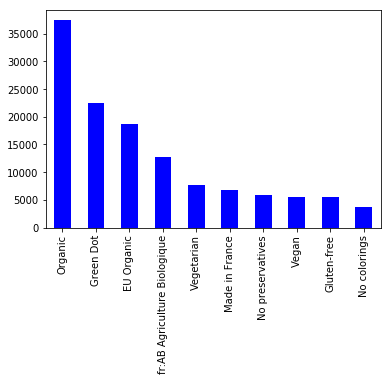

In [79]:
label_flatted["labels"].value_counts().nlargest(10).plot.bar(color='b')
plt.show()

- We can see that the most popular label is organic, there are also a lot of articles having the green dot label which is depicted below for people who do not know what it is. 
- In order here are the most popular labels, unfortunately having an organic label is not a real label. It is a wide concept. Agriculture biologique is a french label. 
<img src="img/eu_organic.jpg" alt="EU Organic" width = 60 height = 60>
<img src="img/green_dot.svg" alt="Green Dot" width = 60 height = 60>
<img src="img/agri_bio.png" alt="Agriculture biologique" width = 60 height = 60>

- We now focus on those three mentionned label to see where we can find them most. 

In [80]:
top_4 = label_flatted["labels"].value_counts().nlargest(4)
top_4 = list(top_4.index)
top_4_articles = label_flatted[label_flatted["labels"].apply(lambda r : r in top_4)]

In [81]:
top_4_all = top_4_articles.join(data_total["origins"], how="inner",lsuffix="l",rsuffix="r").dropna(subset=["origins"])
top_4_all.head()

,labels,origins
code,,
00028202,Green Dot,Royaume-Uni
00035460,Green Dot,Vietnam
00042611,Organic,?
00042611,EU Organic,?
00042611,fr:AB Agriculture Biologique,?


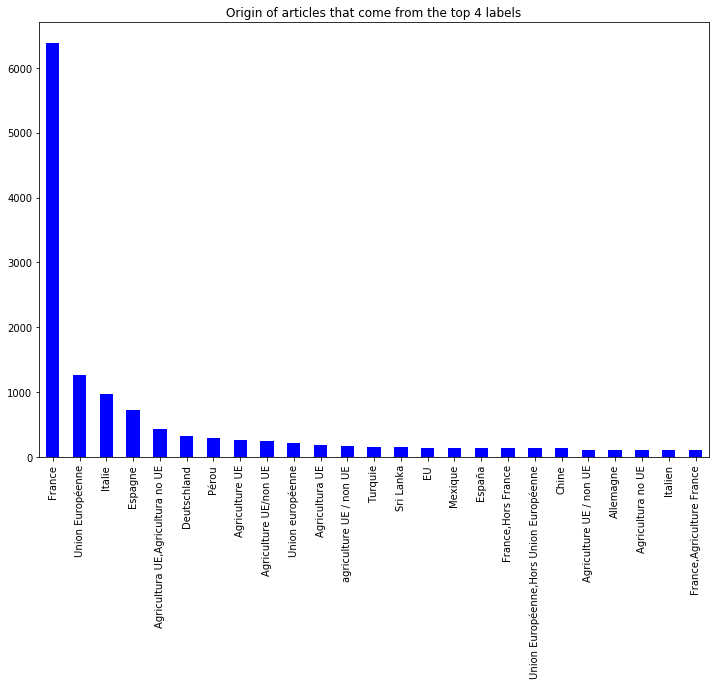

In [82]:
top_4_all["origins"].value_counts().nlargest(25).plot.bar(figsize=(12,8),title="Origin of articles that come from the top 4 labels",color='b')

- We can see that most products come from France however there are a number of articles that come way further than france, it will be interesting to see to study where they are being sold, but this will be done in depth in an other study. 

## Normalization magic 
- We redo the same analysis as done in the palm oil <a href="http://localhost:8888/notebooks/ada_project/Milestone2.ipynb#Now-we-work-on-standarization-of-values.."> here </a>

In [83]:
flatmap = top_4_all["origins"].value_counts().to_frame().head()
flatmap.columns = ["count"]

In [84]:
flatmap.head()

,count
France,6380
Union Européenne,1263
Italie,966
Espagne,734
"Agricultura UE,Agricultura no UE",441


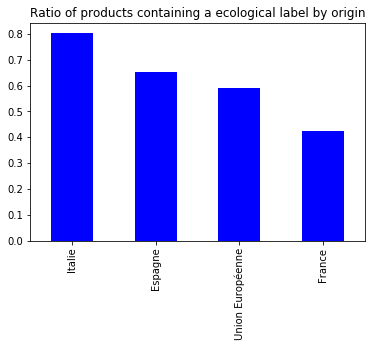

In [85]:
stand = flatmap.join(flatmap_all, lsuffix = "_label", rsuffix ="_total")
stand["ratio"] = stand["count_label"]/stand["count_total"]
stand_best = stand.nlargest(10,"ratio")
stand_best["ratio"].plot.bar(color='b')
plt.title("Ratio of products containing a ecological label by origin")
plt.show()

- This yields only for nations which is a fairly small sample size. 

## Relationship between labels and palm oil usage. 
<p> We now investigate to see if there is any relationship between palm oil and a few labels. This could be user for consumer wanting to avoid palm oil but not wanting to have to read into every ingredients for every product. </p>

In [39]:
# Loading all data. 
data = pd.read_csv("data/cleaned_unique_index.csv",low_memory=False)
data.set_index("code",inplace=True)
palm_oil = pd.read_csv("data/palm_oil.csv")
palm_oil.set_index("code",inplace=True)
palm_oil = palm_oil[palm_oil.ingredients_from_palm_oil_n>0]
label = pd.read_csv("data/labels.csv")
label.set_index("code",inplace=True)


In [40]:
# this is a way to flat map / explode the rows to extract each labels. 
label_flatted = label["labels_en"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()
label_flatted.columns = ["labels"]
label_flatted = label_flatted.reset_index().set_index("code")
label_flatted = label_flatted[["labels"]]
label_flatted.head()

,labels
code,
0000000020114,Made in France
0000000274722,fr:Viande Française
0000003444009,Contains GMOs
0000005200016,Organic
0000007020254,Kosher


In [41]:
## format better labels name because lots of labels have name starting with fr: , en: , de: ...
def strip_preposition(string):
    if (len(string) > 3 and string[2] == ":") or string.startswith("fr:") or string.startswith("en:") or string.startswith("de:"):
        return string[3:]
    else : 
        return string
label_flatted["labels"] = label_flatted["labels"].apply(lambda x : strip_preposition(x))

In [43]:
joined = palm_oil.join(label_flatted)
joined.head()

,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,labels
code,,,,,,,
0000000290616,1.0,NaN,huile-de-palme,0.0,NaN,NaN,NaN
0000010206515,1.0,NaN,huile-de-palme,1.0,NaN,e471-mono-et-diglycerides-d-acides-gras-alimen...,Gluten-free
0000069006562,1.0,NaN,huile-de-palme,0.0,NaN,NaN,NaN
00023092,1.0,NaN,huile-de-palme,0.0,NaN,NaN,NaN
00027083,1.0,NaN,huile-de-palme,3.0,NaN,"e481-stearoyl-2-lactylate-de-sodium,e472e-este...",Gluten-free


In [44]:
def trend_line(data,x,y):
    """
        This plots a trend line on a plot. 
        It is nice to use it on scatter plots. 
    """
    z = np.polyfit(data[x], data[y], 1) # fit it to a polynomial 
    p = np.poly1d(z) # do a 1d polynomial ie. a line. 
    plt.plot(data[x],p(data[x]),color="r")

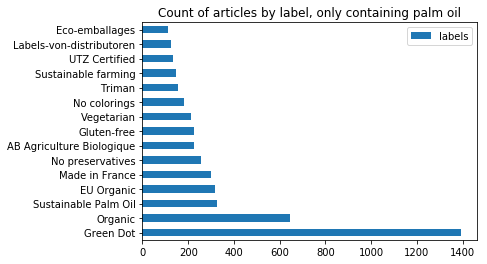

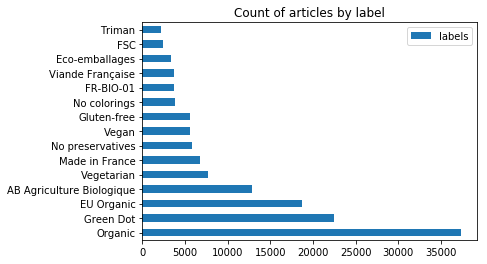

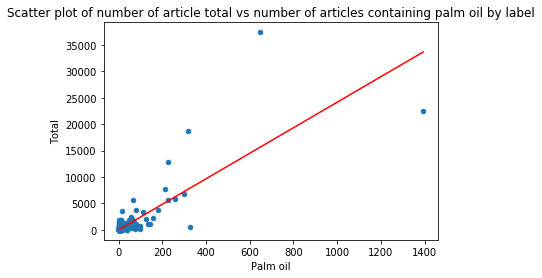

In [45]:
## first plot articles contianing palm oil. 
joined_cnt = joined["labels"].value_counts().to_frame()
joined_cnt.nlargest(15,'labels').plot.barh(title="Count of articles by label, only containing palm oil")
label_cnt = label_flatted["labels"].value_counts().to_frame()
## plot all labels. 
label_cnt.nlargest(15,'labels').plot.barh(title="Count of articles by label")
label_cnt.columns = ["label_cnt"]
joined_cnt.columns=["palm_cnt"]
total = joined_cnt.join(label_cnt)
plt.show()
## Do a scatter plot and add a trend line to see if there is any relation. 
total.plot.scatter("palm_cnt","label_cnt",title="Scatter plot of number of article total vs number of articles containing palm oil by label")
plt.xlabel("Palm oil")
plt.ylabel("Total")
trend_line(total,"palm_cnt","label_cnt")
plt.savefig("correlation_lab_palm.png",bbox_inches="tight")
plt.show()

In [47]:
total["normalized"] = total["palm_cnt"] / total["label_cnt"]

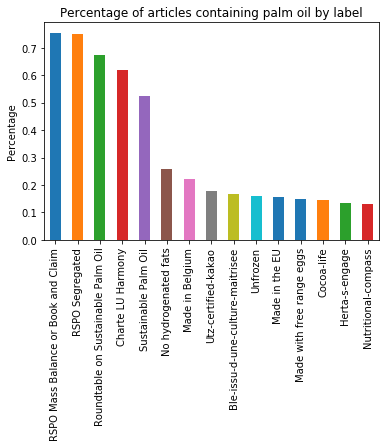

In [60]:
total[total["label_cnt"] > 50]["normalized"].nlargest(15).plot.bar(title="Percentage of articles containing palm oil by label",rot=90)
plt.ylabel("Percentage")
plt.savefig("img/labels/palm_oil_labels_normalized.png",bbox_inches='tight')

## Discussion 
<p> RSPO means roundtable on sustainable palm oil. Its an organization working towards sustainable use of palm oil</p>
<p> Therefore there is no surprise when we see that the labels containing the most palm oil products are the one that have to do with RSPO. However we can see that UTZ cacao products will often contain palm oil, and also Cocoa life. </p>
<p> Hence a consumer wanting to avoid palm oil should definetly be on the look out for those labels. </p> 

# Association rule learning

In [90]:
del data


UsageError: Line magic function `%which` not found.


In [92]:

ORIGINS=pd.read_csv(DATAPATH + 'quick_translate_origins.csv')
data_u =  pd.read_csv(DATAPATH+'cleaned_unique_index.csv',low_memory=False)
data_u.set_index('code',inplace =True)

In [93]:
data_labels=data_u.labels_en.dropna().str.split(',')
data_labels_exploded=data_labels.apply(pd.Series).unstack().dropna()
data_categories=data_u.categories_en.dropna().str.split(',')
data_categories_exploded=data_categories.apply(pd.Series).unstack().dropna()

In [94]:
z=pd.DataFrame(data_labels_exploded).reset_index().set_index("code")[[0]]
z.columns=['label']
x=pd.DataFrame(data_categories_exploded).reset_index().set_index('code')[[0]]
x.columns=['category']

In [95]:
organic=z[z['label'] == 'Organic']
green_dot=z[z['label'] == 'Green Dot']
eu_organ=z[z['label'] == 'EU Organic']
z=pd.concat([organic,green_dot,eu_organ])

In [126]:
ORIGINS=pd.read_csv(DATAPATH + 'quick_translate_origins.csv')
ORIGINS=ORIGINS.reset_index().set_index('code').drop(columns='index')

In [127]:
z=pd.DataFrame(data_labels_exploded).reset_index().set_index("code")[[0]]
z.columns=['label']
x=pd.DataFrame(data_categories_exploded).reset_index().set_index('code')[[0]]
x.columns=['category']
origins_=ORIGINS


f=x.join(z).dropna()
f['joined']=f['category']+','+f['label']


In [129]:
highest_support=pd.Series(f['joined'].value_counts().head(20).index.values)

grouped_=list(zip(*(highest_support.str.split(',').values)))
highest_categories=np.unique(list(grouped_[0]))
highest_labels=np.unique(list(grouped_[1]))
highest_categories=highest_categories.tolist()
highest_labels=highest_labels.tolist()

### Similarity 
<p> Below are the different functions for similarity which the formula can be found below. </p> 

In [130]:
def cosine_similarity(array1,array2):
    return np.divide(np.dot(array1,array2),norm(array1)*norm(array2))

In [131]:
def pearson_similarity(array1,array2):
    array1_=np.subtract(array1,np.mean(array1))
    array2_=np.subtract(array2,np.mean(array2))
    return np.divide(np.dot(array1_,array2_),norm(array1_)*norm(array2_))

In [132]:
def tanimoto_similarity(array1,array2):
    dividende=np.dot(array1,array2)
    divisor=np.dot(array1,array1)+np.dot(array2,array2)-dividende
    return dividende/divisor

In [86]:
def define_local_rules(origin=None,origins_=origins_):
    """
    defines the local rules for a given origin in the dataset. 
    
    """
    local_rules={}
    x_=x.copy()
    z_=z.copy()
    if origin:

        origins_=origins_[origins_['origin']==origin]
        z_=z.join(origins_).dropna().drop(columns=['origin'])
        x_=x.join(origins_).dropna().drop(columns=['origin'])



    f=x_.join(z_).dropna()
    f['joined']=f['category']+','+f['label']
    support=f['joined'].value_counts()
    label_counts=z_['label'].value_counts()
    category_counts=x_['category'].value_counts()

    for label in highest_labels:

        for category in highest_categories:


            string_=category+','+label
            if string_ in support.index:
                local_rules[label+' -> '+category]=support.loc[category+','+label]/label_counts.loc[label]
                local_rules[category+' -> '+label]=support.loc[category+','+label]/category_counts.loc[category]
            else:
                local_rules[label+' -> '+category]=0.
                local_rules[category+' -> '+label]=0.
    return local_rules.copy()

In [157]:
general_local_rules=define_local_rules()
germany_local_rules=define_local_rules('Germany')
france_local_rules=define_local_rules('France')
belgium_local_rules=define_local_rules('Belgium')
spain_local_rules=define_local_rules('Spain')
italy_local_rules=define_local_rules('Italy')
switzerland_local_rules=define_local_rules('Switzerland')

### How to use : 
<p> Below we can see how to use the rules. For instance if a product is organic, the probability of it being a beverage is 12%. The reciprocal probability is 15%. </p> 

In [158]:
print(general_local_rules['Organic -> Beverages'])
print(general_local_rules['Beverages -> EU Organic'])
print(general_local_rules['EU Organic -> Beverages'])
print(general_local_rules['Beverages -> Organic'])

0.1211140242923645
0.08018754093839418
0.12448488092052448
0.15606577722618678


### Comparison at large scale

Because it can be tedious to compare each rule one after one other, considering local rules values as vectors can allow to compare them in a faster way. 

There are several ways to compute vector similiraty, here we use three of them:
 * linear correlation
 $$\frac{Cov(x,y)}{\sqrt{ Var(x)Var(y)}}$$
 * cosine similarity
 $$\frac{\sum x_i y_i}{\sqrt{ \sum{x_i^2} \sum{y_i^2}}}$$
 * Tanimoto distance
 $$\frac{\sum x_i y_i}{\sum{x_i^2} + \sum{y_i^2} -\sum x_i y_i}$$
 
 As there is no theoretical reason to prefer one of them, they are all computed and compared.
 It turns out that they are equivalent **in the selected countries**:  sim1(country A, country B) < sim1(countryC, countryD) iff sim2(country A, country B) < sim2(countryC, countryD)


In [159]:
values=np.zeros((7,len(general_local_rules)))
values[0]=list(general_local_rules.values())
values[1]=list(germany_local_rules.values())
values[2]=list(france_local_rules.values())
values[3]=list(belgium_local_rules.values())
values[4]=list(spain_local_rules.values())
values[5]=list(italy_local_rules.values())
values[6]=list(switzerland_local_rules.values())

In [160]:
cosine_similarities = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        cosine_similarities[i,j]=cosine_similarity(values[i],values[j])

In [161]:
cosine_similarity_frame=pd.DataFrame(cosine_similarities)
cosine_similarity_frame.columns=['World','Germany','France','Belgium','Spain','Italy','Switzerland']
cosine_similarity_frame.index=['World','Germany','France','Belgium','Spain','Italy','Switzerland']

In [162]:
pearson_similarities = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        pearson_similarities[i,j]=pearson_similarity(values[i],values[j])

In [163]:
pearson_similarity_frame=pd.DataFrame(pearson_similarities)
pearson_similarity_frame.columns=['World','Germany','France','Belgium','Spain','Italy','Switzerland']
pearson_similarity_frame.index=['World','Germany','France','Belgium','Spain','Italy','Switzerland']

In [164]:
tanimoto_similarities = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        tanimoto_similarities[i,j]=tanimoto_similarity(values[i],values[j])

In [165]:
tanimoto_similarity_frame=pd.DataFrame(tanimoto_similarities)
tanimoto_similarity_frame.columns=['World','Germany','France','Belgium','Spain','Italy','Switzerland']
tanimoto_similarity_frame.index=['World','Germany','France','Belgium','Spain','Italy','Switzerland']

In [166]:
print('Cosine similarities')
cosine_similarity_frame

Cosine similarities


,World,Germany,France,Belgium,Spain,Italy,Switzerland
World,1.000000,0.889680,0.918936,0.747011,0.884219,0.911201,0.777125
Germany,0.889680,1.000000,0.844795,0.735398,0.796885,0.890072,0.754714
France,0.918936,0.844795,1.000000,0.759789,0.765514,0.907996,0.747664
Belgium,0.747011,0.735398,0.759789,1.000000,0.647239,0.754882,0.542345
Spain,0.884219,0.796885,0.765514,0.647239,1.000000,0.820606,0.643279
Italy,0.911201,0.890072,0.907996,0.754882,0.820606,1.000000,0.760406
Switzerland,0.777125,0.754714,0.747664,0.542345,0.643279,0.760406,1.000000


In [167]:
print('Linear correlation similarities')
pearson_similarity_frame

Linear correlation similarities


,World,Germany,France,Belgium,Spain,Italy,Switzerland
World,1.000000,0.765359,0.806923,0.530590,0.803176,0.798681,0.567605
Germany,0.765359,1.000000,0.659701,0.523093,0.640157,0.767872,0.540049
France,0.806923,0.659701,1.000000,0.549313,0.567002,0.784491,0.497412
Belgium,0.530590,0.523093,0.549313,1.000000,0.414235,0.548256,0.213890
Spain,0.803176,0.640157,0.567002,0.414235,1.000000,0.679774,0.391806
Italy,0.798681,0.767872,0.784491,0.548256,0.679774,1.000000,0.536926
Switzerland,0.567605,0.540049,0.497412,0.213890,0.391806,0.536926,1.000000


In [168]:
print('Tanimoto distance similarities')
tanimoto_similarity_frame

Tanimoto distance similarities


,World,Germany,France,Belgium,Spain,Italy,Switzerland
World,1.000000,0.775679,0.839159,0.578073,0.620036,0.705175,0.511653
Germany,0.775679,1.000000,0.727945,0.518688,0.597663,0.756954,0.552306
France,0.839159,0.727945,1.000000,0.566607,0.537630,0.755910,0.522579
Belgium,0.578073,0.518688,0.566607,1.000000,0.333859,0.450459,0.268063
Spain,0.620036,0.597663,0.537630,0.333859,1.000000,0.689595,0.474088
Italy,0.705175,0.756954,0.755910,0.450459,0.689595,1.000000,0.609418
Switzerland,0.511653,0.552306,0.522579,0.268063,0.474088,0.609418,1.000000


### Data Viz

Previous method suggest different shades of similarities: e.g Switzerland and Belgium are less similar than France and Italy.

To represent those similarities in a more direct way via data visualization. An immediate drawback of that approach is that we need to project the local rule values onto a 2D space for representation sake. This dimensionality reduction is surely to high.

We used three method
 * PCA: this method directly project the data onto a space were the new features are uncorrelated. PCA is often used to reduce dimensionality by taking the principal components with highest variances. However, it only takes in account linear correlation and not depances in general.
 * ICA: coming from signal source demixing problem, ICA tries to retrieve the weights of the different sources, under the assumption that the pure sources are non gaussian.
 * Autoencoder: a techniques based on neural network. the NN is  has different hidden layers, including the coder which has usually a low number of neurons. The NN is trained to reproduced the same data from input to output. Once trained, values at the coder layer represent a non-linear projection of data onto a lower dimensional space.

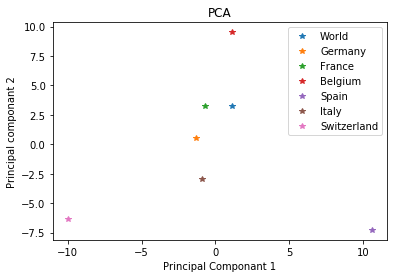

In [169]:
std_values=np.subtract(values,values.mean(axis=0))
std_values=np.divide(std_values,std_values.std(axis=0)+1e-14)
pca=PCA(n_components=2)
pca_results=pca.fit_transform(std_values)
for i in range(7):
    plt.plot(pca_results[i,0],pca_results[i,1],'*')
plt.legend(['World','Germany','France','Belgium','Spain','Italy','Switzerland'])
plt.title('PCA')
plt.xlabel('Principal Componant 1')
plt.ylabel('Principal componant 2')
plt.savefig('PCA.png',bbox_inches='tight')
plt.show()


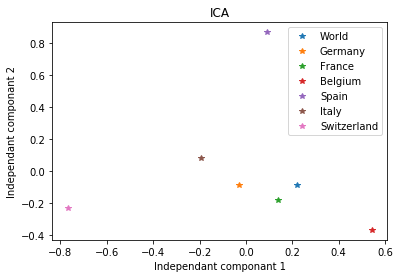

In [170]:
fast_ica=FastICA(n_components=2)
fast_ica_results=fast_ica.fit_transform(std_values)
for i in range(7):
    plt.plot(fast_ica_results[i,0],fast_ica_results[i,1],'*')
plt.legend(['World','Germany','France','Belgium','Spain','Italy','Switzerland'])
plt.title('ICA')
plt.xlabel('Independant componant 1')
plt.ylabel('Independant componant 2')
plt.savefig('ICA.png',bbox_inches='tight')
plt.show()


In [171]:
input_=Input(shape=(values.shape[1],))
first_layer=Dense(128,activation='selu')(input_)
second_layer=Dense(64,activation='selu')(first_layer)
coder=Dense(2,activation='linear')(second_layer)
decode_second_layer=Dense(64,activation='selu')(coder)
decode_first_layer=Dense(128,activation='selu')(decode_second_layer)
output=Dense(values.shape[1],activation='linear')(decode_first_layer)

autencoder=Model(input_,output)
encoded=Model(input_,coder)
autencoder.compile(optimizer='adam',loss='mean_squared_error')


In [172]:
history=autencoder.fit(std_values,std_values,epochs=300,verbose=0)

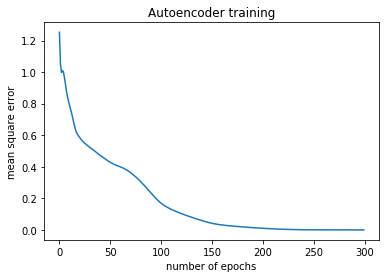

In [173]:
plt.plot(history.history['loss'])
plt.xlabel('number of epochs')
plt.ylabel('mean square error')
plt.title('Autoencoder training')
plt.show()

In [174]:
encoded_values=encoded.predict(std_values)

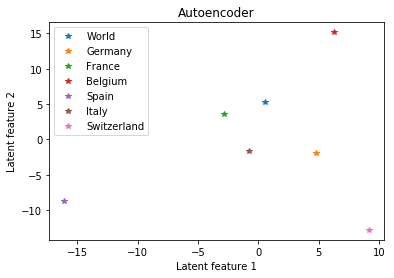

In [175]:
for i in range(7):
    plt.plot(encoded_values[i,0],encoded_values[i,1],'*')
plt.legend(['World','Germany','France','Belgium','Spain','Italy','Switzerland'])
plt.legend(['World','Germany','France','Belgium','Spain','Italy','Switzerland'])
plt.title('Autoencoder')
plt.xlabel('Latent feature 1')
plt.ylabel('Latent feature 2')
plt.savefig('autoencoder.png',bbox_inches='tight')
plt.show()

### Discussion 
<p> We can see with the neural net that France, Italy and Germany are close. However, Spain, Switzerland and Belgium are outliers </p>

## Graphs about imports to France
<p> As stated in our milestone 2, we wanted to focus more on France as a country because it contained the most items in the dataset. Hence we are here doing some computation to see where most of the products consummed in france come from. 
Then we will compute and see how much distance they might have travelled ! </p>

In [3]:
import networkx as nx
## This is a utility method that helps to draw graphs easily. 

def do_star_graph_series(series,center=None,node_color='pink',font_color='black',mode='node',title='',save_under=''):
    """
    This draws a star graph with a central node and all around it nodes with values from the serie. 
    
    series : the pandas serie to pass. It needs to have an index. moreover it needs to have values > 0 if you want to use the edge mode
    node_color, font_color -> color for the node and background 
    mode: three modes : 'node' the value of the serie will influence on the size of the node, 'edge' value of series will influence the color of hte node , 'both' ( not recommended its ugly and confusing just here as a proof of concept..) : does both
    title: title of graph
    save_under : if you want to save the graph under a title..
    """
    labs = []
    if 0 in series:
        print("PSA : using a 0(or negative value) in the series does not work with edge mode.")
    if center != None:
    ## prepare the labels of the nodes. 
        labs = [center]+list(series.index)
    else:
        labs = ['']+list(series.index)
    labs = dict(zip(labs,labs))

    # setup graph and add nodes. 
    g = nx.DiGraph()
    i = 1
    if center != None:
        g.add_star([center]+list(series.index))
    else :
        g.add_star(['']+list(series.index))
        
    # just a layout. 
    pos = nx.layout.spring_layout(g)

    if mode=='both':
        
        node_sizes = [100]+list(series.values.ravel())
        edge_colors =list(map(math.log*100,series.values.ravel()))    
        nodes = nx.draw_networkx_nodes(g,pos,node_size=node_sizes,node_color=node_color)
        edges = nx.draw_networkx_edges(g,pos,node_size=node_sizes,arrowstyle='->',arrowsize=10,width = 2,edge_cmap = plt.cm.winter,edge_color=edge_colors)
        pc = mpl.collections.PatchCollection(edges,cmap=plt.cm.winter)
        pc.set_array(edge_colors)
        plt.colorbar(pc)

    elif mode=='edge':
        # have map for edge color.. we use logscale 
        edge_colors =list(map(math.log,series.values.ravel()))
        nodes = nx.draw_networkx_nodes(g,pos,node_color=node_color)
        node_sizes = [100]+list(series.values.ravel())

        edges = nx.draw_networkx_edges(g,pos,node_size=node_sizes,arrowstyle='->',arrowsize=10,width = 2,edge_cmap = plt.cm.winter,edge_color=edge_colors)
        # add the colorbar to help understand the colors. 
        pc = mpl.collections.PatchCollection(edges,cmap=plt.cm.winter)
        pc.set_array(edge_colors)
        plt.colorbar(pc)
    elif mode=='node':
        node_sizes = [100]+list(series.values.ravel())
        nodes = nx.draw_networkx_nodes(g,pos,node_size=node_sizes,node_color=node_color)
        edges = nx.draw_networkx_edges(g,pos,node_size=node_sizes,arrowstyle='->',arrowsize=10,width = 2)
    ## add labels. 
    labels = nx.draw_networkx_labels(g,pos,labels=labs,font_color=font_color)


    ##remove axis, set size, add title..
    ax = plt.gca()
    ax.set_axis_off()
    fig = plt.gcf()
    fig.set_size_inches(14,10)
    plt.title(title)
    if len(save_under) > 0 :
        plt.savefig(save_under)
    plt.show()

In [39]:
# This flatmaps the categories ( I wish pandas had flat map. )
z = data
z = z[["categories_en"]]
z = z["categories_en"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()
z = z.reset_index().set_index('code')
z.columns = ['','categories_en']
categories_split = z[['categories_en']]
categories_split.head()

In [82]:
food_origins = pd.read_csv(DATAPATH+"/food_origins.csv")


In [23]:

origins_france = data.set_index('code')['France' == data.set_index('code')['countries_en']][['origins_tags']].dropna()
# flatmap 
z = origins_france["origins_tags"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()
z = z.reset_index().set_index('code')
z.columns = ['','origins_tags']
origins_split = z[['origins_tags']]


In [33]:
grouped = origins_split['origins_tags'].value_counts().to_frame()
grouped.columns=['count']
exclude = ['provence','agriculture-ue','ue','lait-origine-france','sud-ouest','hors-france','normandie','hors-union-europeenne','agriculture-ue-non-ue','union-europeenne','bretagne']
for e in exclude : 
    grouped = grouped[grouped.index != e]
top15 = grouped.nlargest(15,'count')


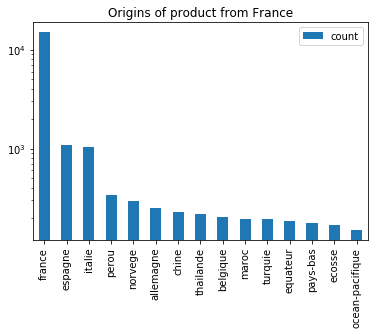

In [32]:
top15.plot.bar(logy=True,title='Origins of product from France')
plt.show()

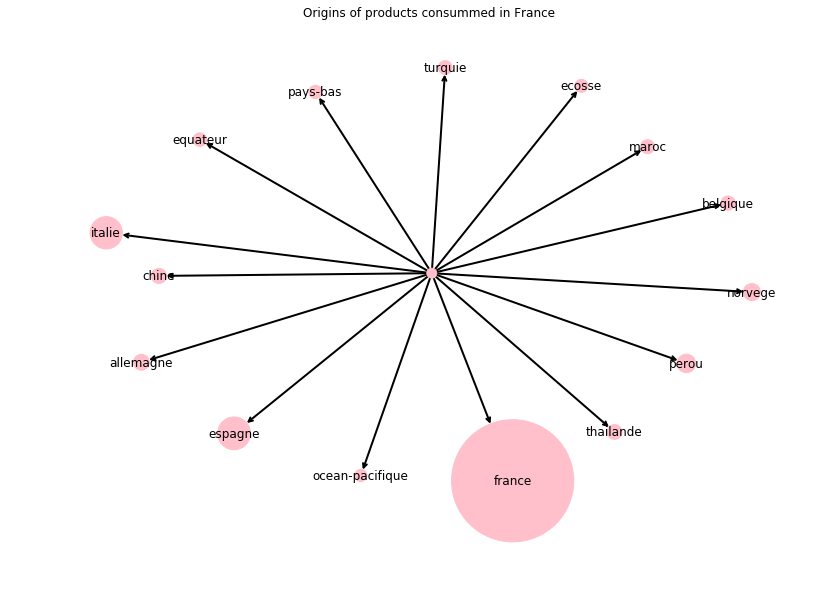

In [46]:
do_star_graph_series(top15,title='Origins of products consummed in France')

<p> We can see that the big majority of products consummed by the french population are from france. This could be seen as encouraging because it would mean they consume fairly locally. 
</p>
<p>
However now we will investigate how much the products travel first in general and then by categories </p>
<p> First see what kind of products are consummed in France </p>

In [50]:
z = origins_france.join(data.set_index('code'),lsuffix='l',rsuffix='r')
z = z[["categories_en"]]
z = z["categories_en"].str.split(',').apply(pd.Series).unstack().dropna().to_frame()
z = z.reset_index().set_index('code')
z.columns = ['','categories_en']
categories_split = z[['categories_en']]


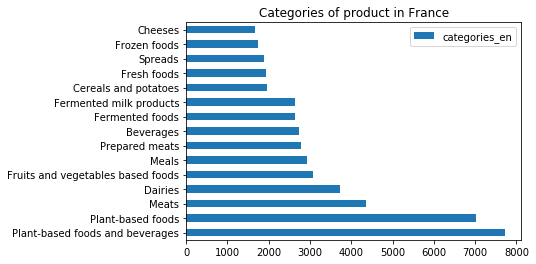

In [53]:
by_cat_france = categories_split["categories_en"].value_counts().to_frame()
by_cat_15 = by_cat_france.nlargest(15,'categories_en')
by_cat_15.plot.barh(title="Categories of product in France")
plt.show()

<p> The majority of products are plant-based foods and beverages. Which entails vegetables, fruits and everything related to plants </p>

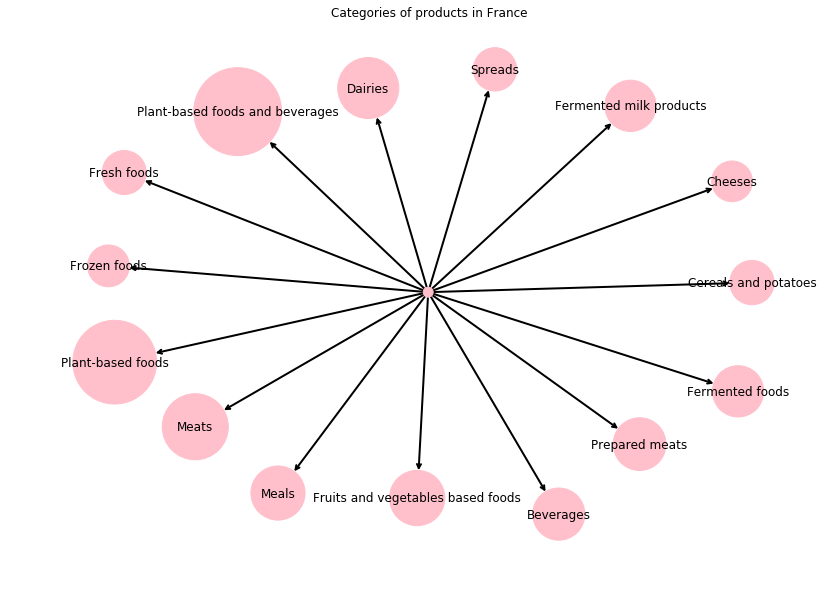

In [57]:
do_star_graph_series(by_cat_15,title="Categories of products in France")

In [63]:
def star_network_and_chart(dataframe,category,title=""):
    """
    do a star network and a bar chart with the given dataframe on the given coloumn 
    optionaly have title..
    """
    cat_pd = dataframe[category ==  dataframe["categories_en"]]
    origin_category = cat_pd.join(origins_split)
    top10 = origin_category["origins_tags"].value_counts().to_frame().nlargest(10,"origins_tags")
    do_star_graph_series(top10,mode='node',title=title)
    top10.plot.barh(title=title)
    plt.show()

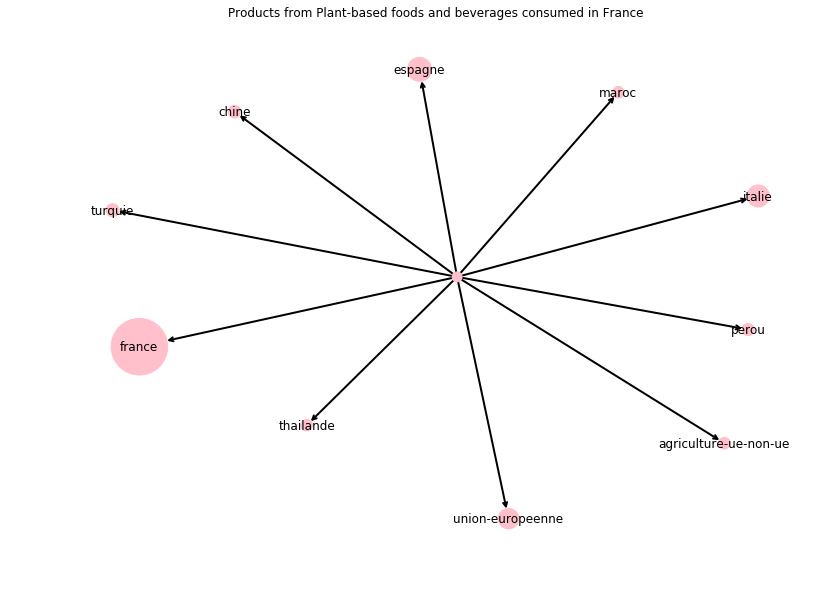

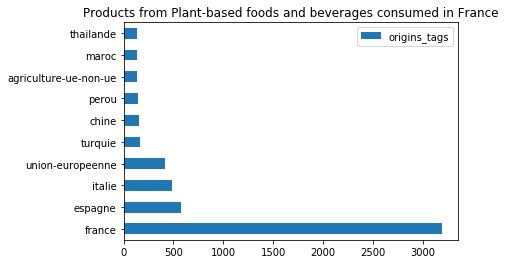

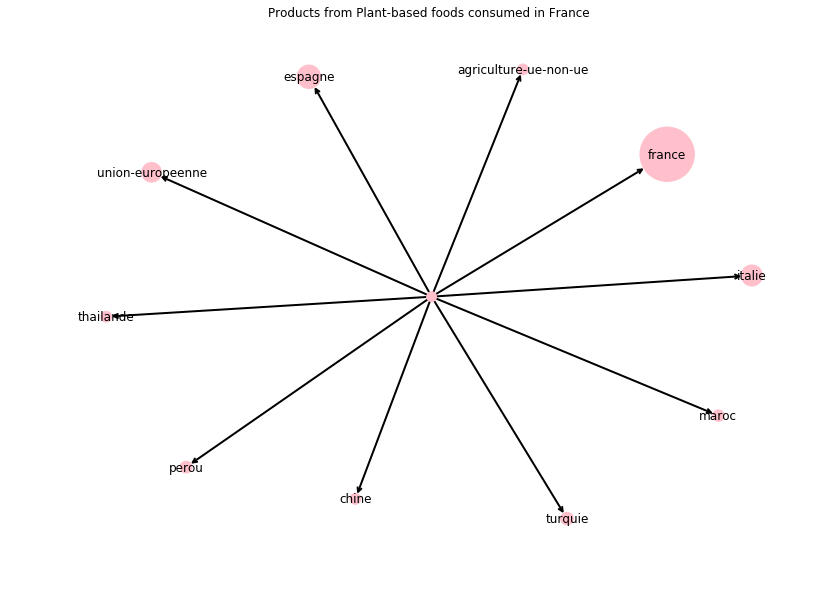

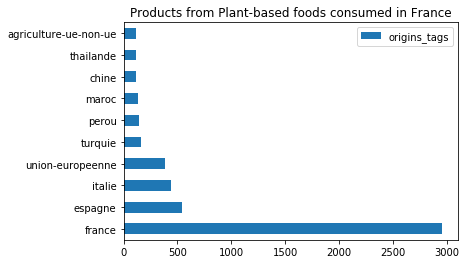

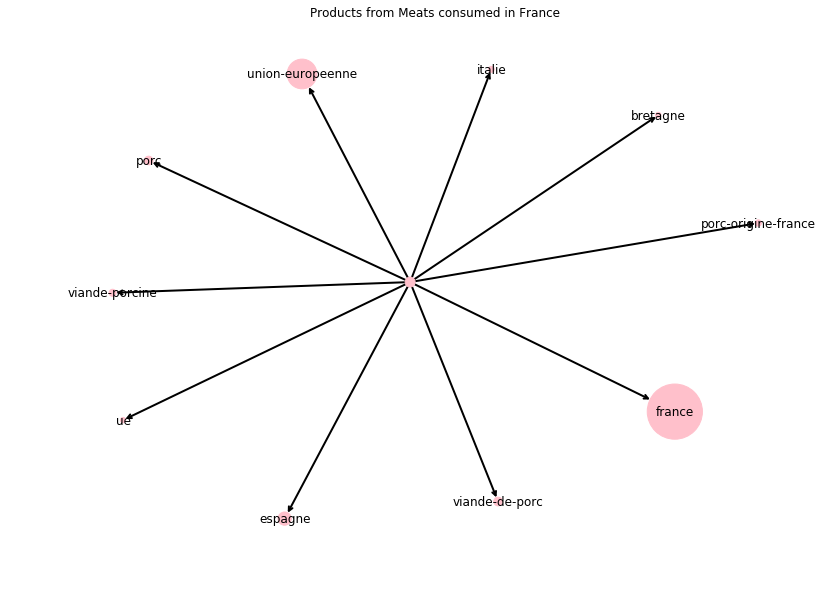

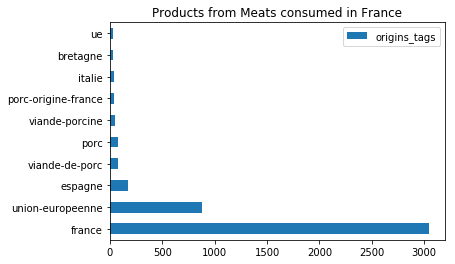

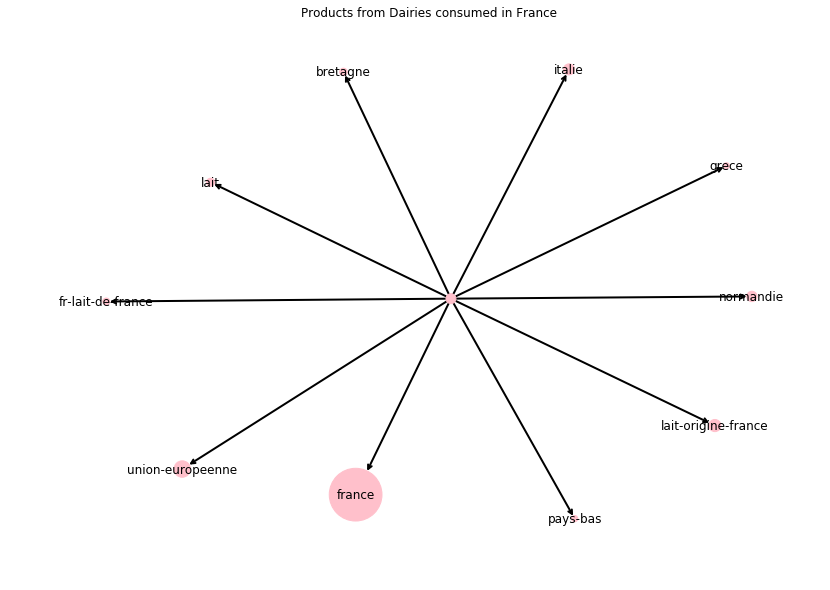

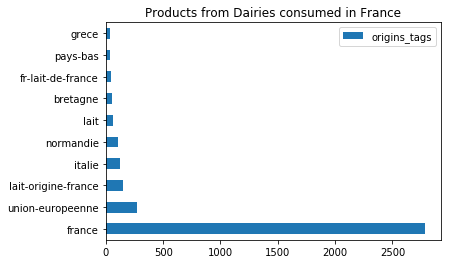

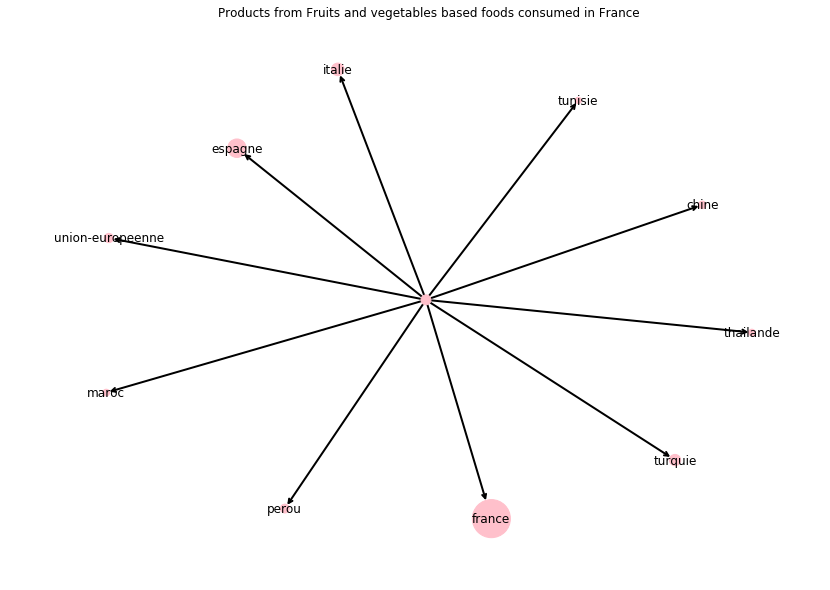

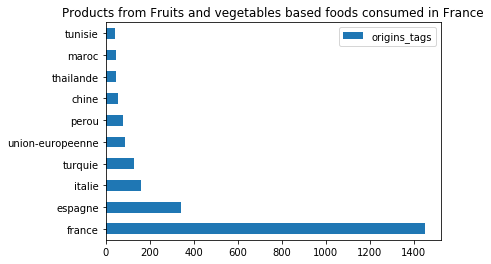

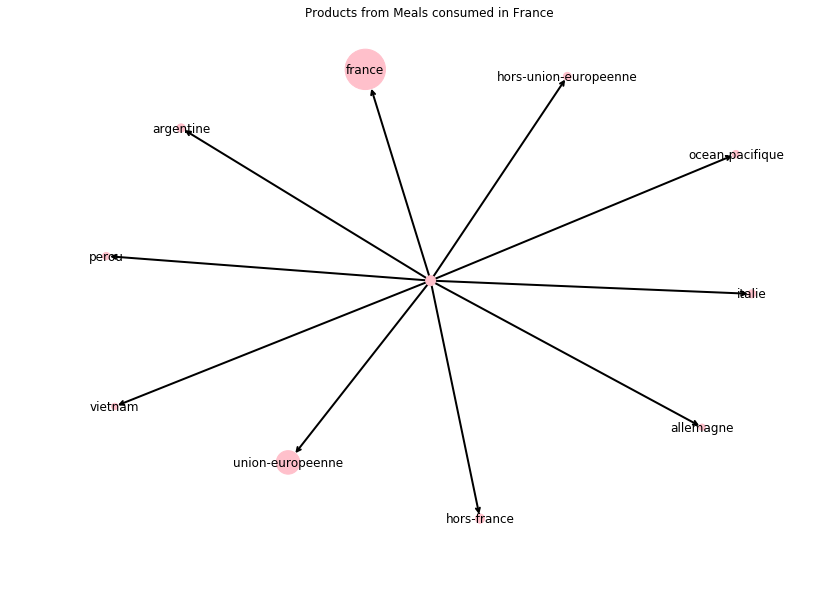

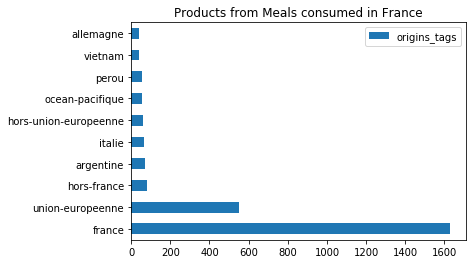

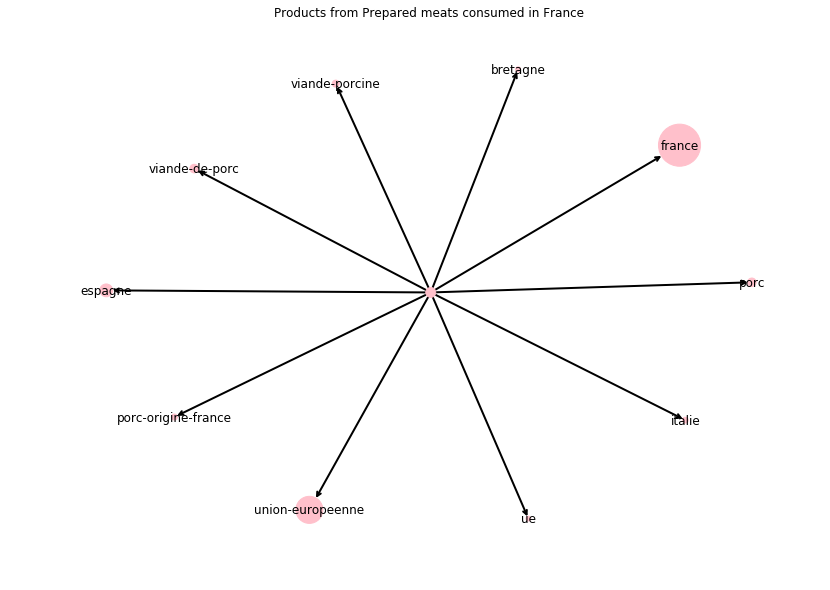

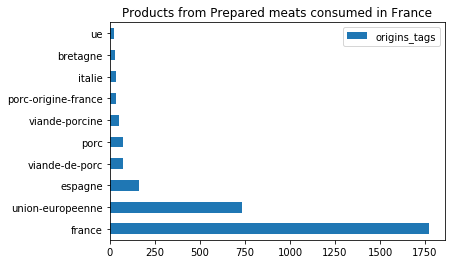

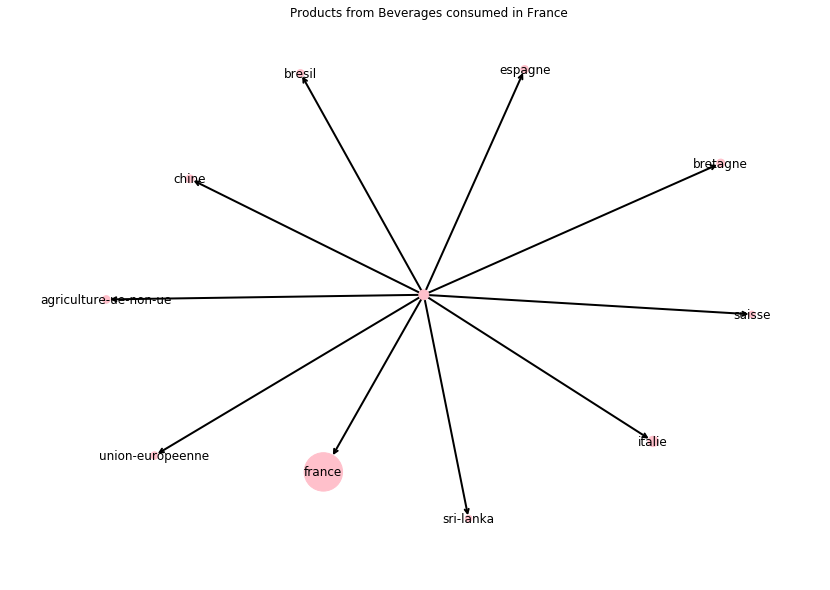

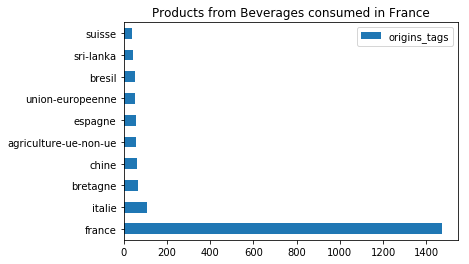

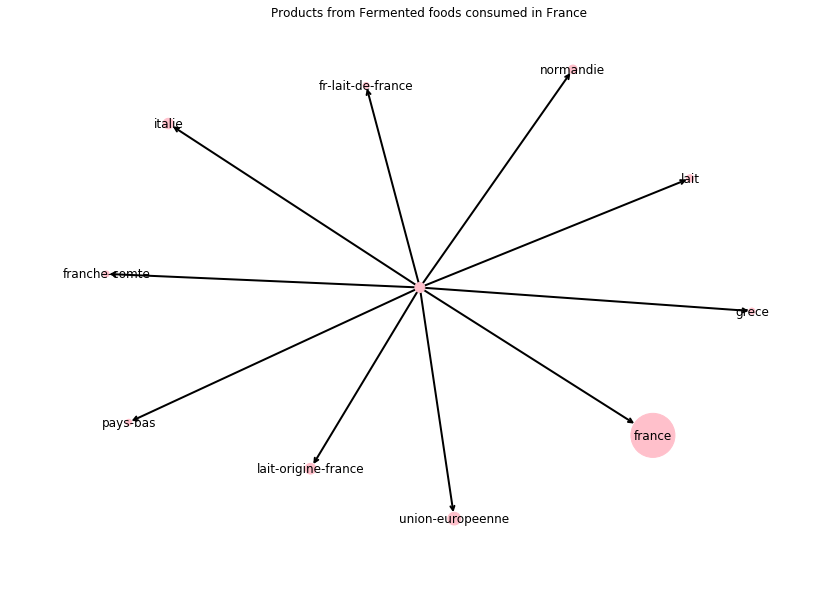

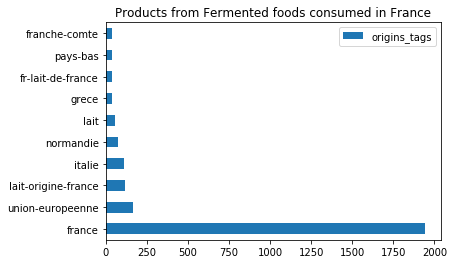

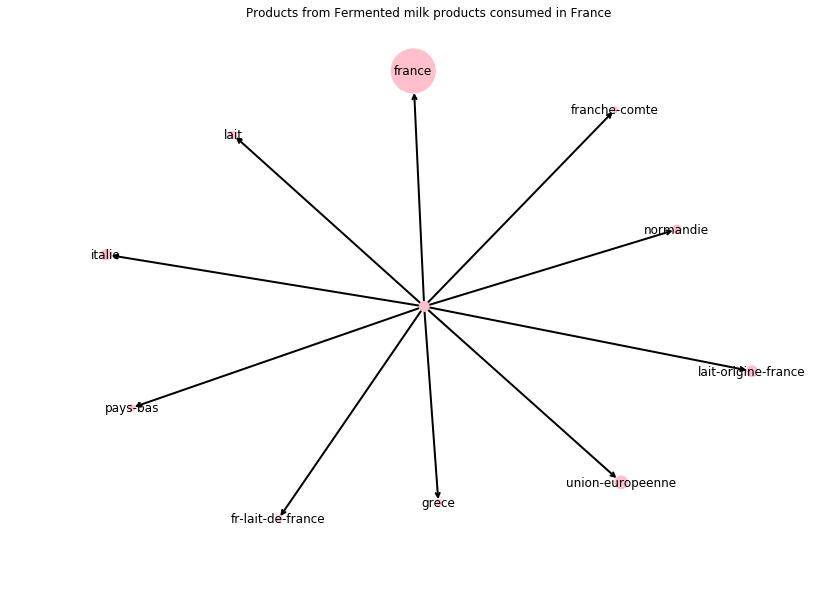

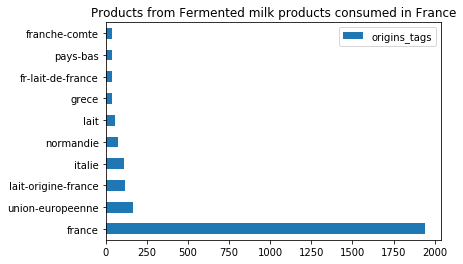

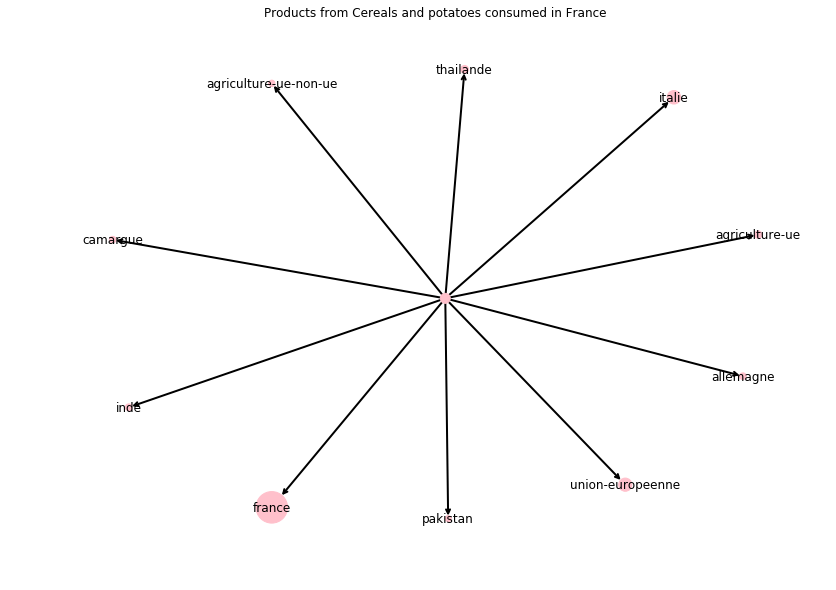

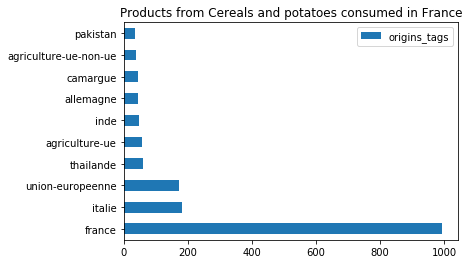

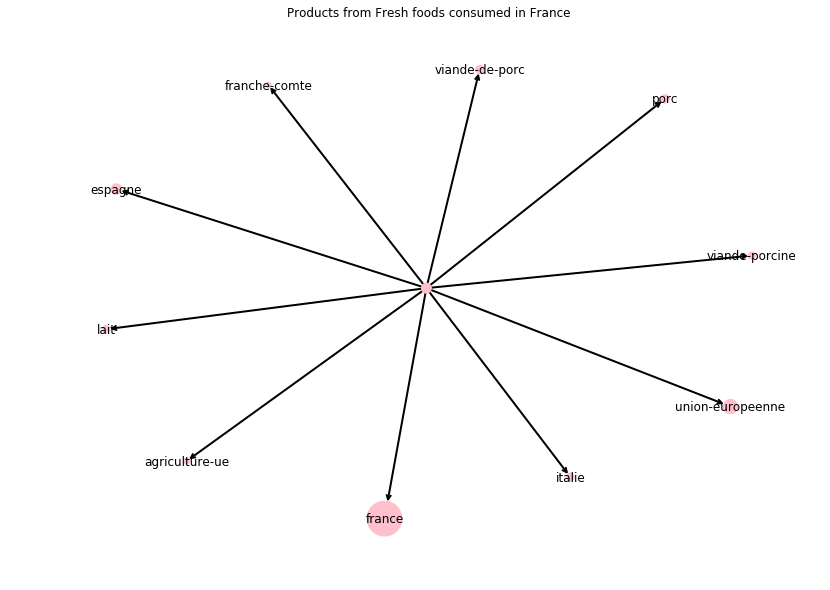

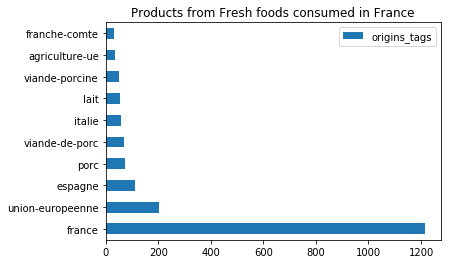

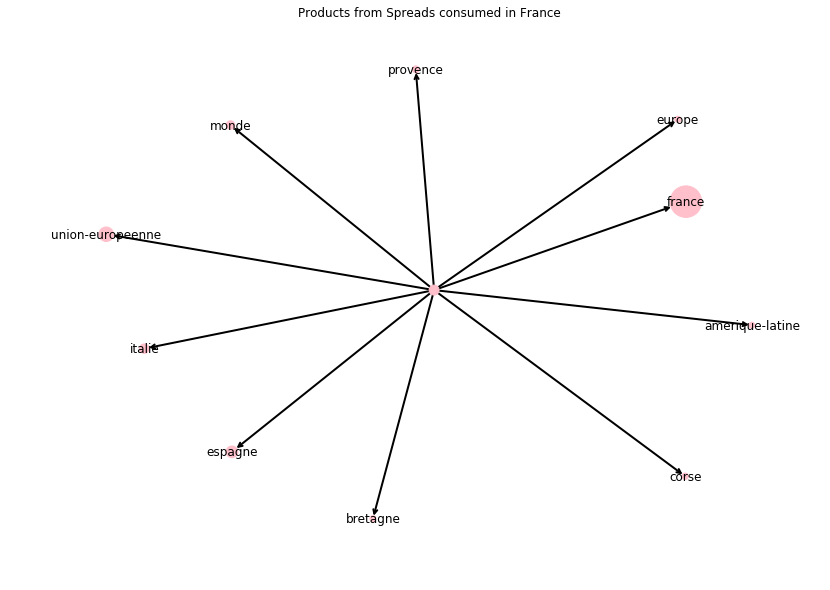

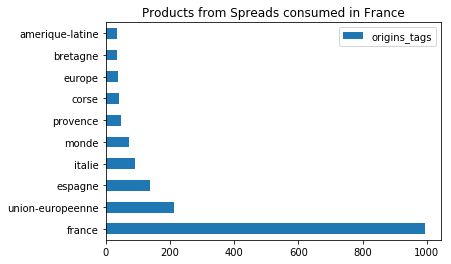

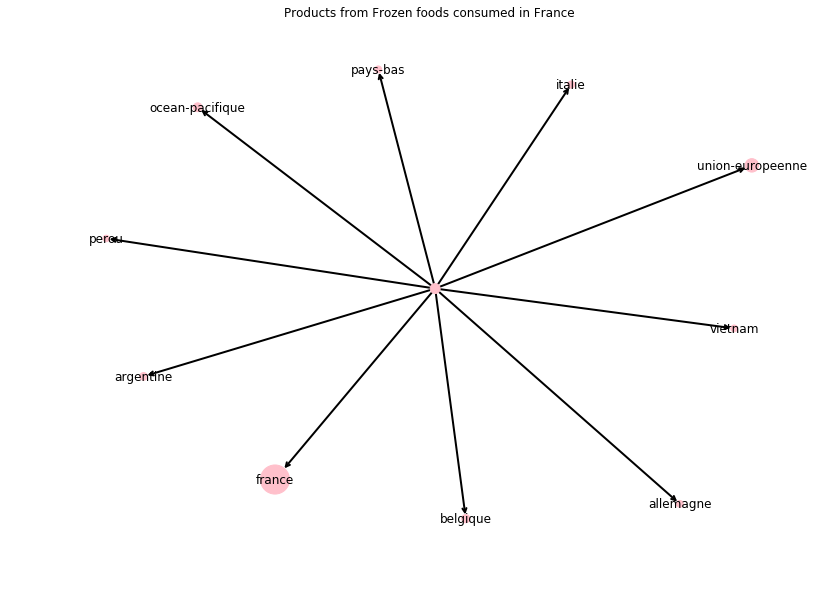

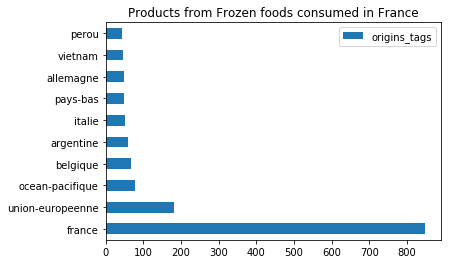

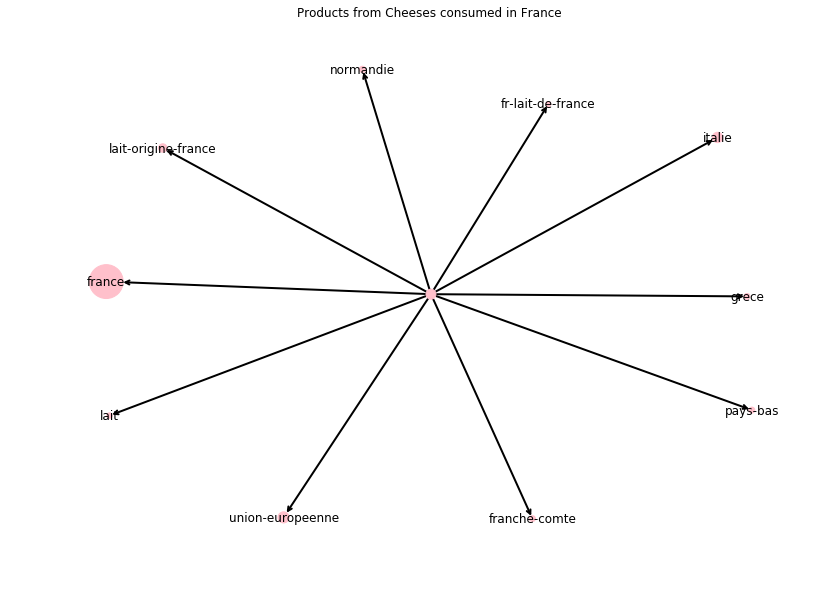

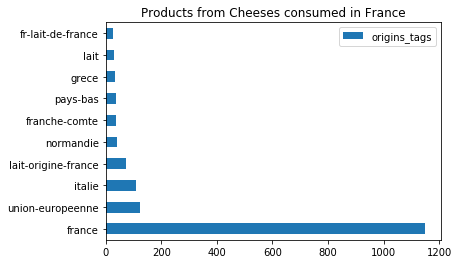

In [64]:
for cat in by_cat_15.index:
    star_network_and_chart(categories_split,cat,title="Products from "+cat+" consumed in France")

### Discussion 
<p> We see that again most products come from France, however when looking at dairy product here almost all of them are produced in france which is an interesting fact. </p>
<p> Prepared meals however are not so precise with many of them being produced in the european union which must then have to be transported by plane or bus..</p>

## By category distance 

<p> We now focus on the distance covered for each category of products. This could lead to some hindsight as to what kind of products is more homegrown. </p>

### Method 
<p> We first load the data, then we use the dictionary in order to have same country under the same name. </p>
<p> after a few manipulations we can isolate the by categories and then display by categories the distance travelled </p>  

In [4]:
data = pd.read_csv('openfoodfacts.csv',delimiter='\t',low_memory = False)
distance_df = pd.read_csv('data/DistancePerProduct.csv')
dico = pd.read_csv("data/Destination-Coordinate-MAN.csv")
dico = dico[["destination","country"]]

dico_d = dict(zip(dico["destination"],dico["country"]))
## apply the dico. 
data["countries_en"] = data["countries_en"].apply(lambda x : dico_d.get(x))

In [5]:

distance_df.set_index('Unnamed: 0',inplace=True)
distance_df.index.name = ''



In [24]:
## We select only french products. 
z = data[data["countries"] == "France"].join(distance_df).dropna(subset=['distance'])
z.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,distance
251,0000000274722,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1514659309,2017-12-30T18:41:49Z,1535310176,2018-08-26T19:02:56Z,Blanquette de Volaille et son Riz,Blanquette de Volaille et son Riz,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0 km
292,0000007730009,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1462806432,2016-05-09T15:07:12Z,1482359150,2016-12-21T22:25:50Z,Biscuits sablés fourrage au cacao,Biscuits sablés déclassés fourrage au cacao,1 kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336.2788495858375 km
299,0000009336247,http://world-en.openfoodfacts.org/product/0000...,tacite,1479029877,2016-11-13T09:37:57Z,1537983444,2018-09-26T17:37:24Z,Bonbons acidulés Raisin Fraise,Bonbons acidulés Raisin Fraise,"46,7 g",...,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7734.861776902698 km
305,0000010090206,http://world-en.openfoodfacts.org/product/0000...,sebleouf,1370977431,2013-06-11T19:03:51Z,1445083431,2015-10-17T12:03:51Z,Thé de Noël aromatisé orange-cannelle,NaN,75 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0 km
356,0000020004552,http://world-en.openfoodfacts.org/product/0000...,agamitsudo,1474099741,2016-09-17T08:09:01Z,1501529116,2017-07-31T19:25:16Z,Côtes du Rhône Villages 2014,NaN,75 cl e,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0 km


In [26]:
## Explode the categroies...
explode = z['categories_en'].str.split(',').apply(pd.Series).unstack().dropna().to_frame()
explode = explode.reset_index().set_index('level_1')
explode = explode.drop(['level_0'],axis=1)
explode.index.name=''
merged = explode.join(z)


In [33]:
largest = explode[explode[0].apply(lambda x : not x.startswith('en:'))][0].value_counts().nlargest(15)

In [34]:
largest

Plant-based foods and beverages      10898
Plant-based foods                     9808
Sugary snacks                         5160
Meals                                 4811
Dairies                               4447
Beverages                             4441
Meats                                 4439
Fruits and vegetables based foods     3963
Fermented foods                       3178
Fermented milk products               3176
Cereals and potatoes                  3161
Biscuits and cakes                    2879
Prepared meats                        2866
Spreads                               2650
Frozen foods                          2603
Name: 0, dtype: int64

Plant-based foods and beverages


C:\Users\johan\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


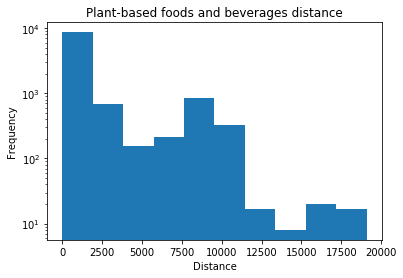

-------------
Plant-based foods


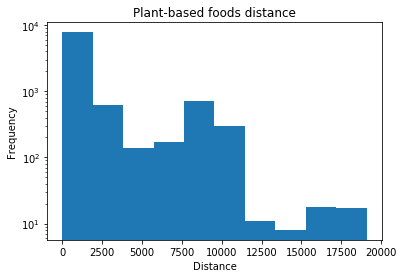

-------------
Sugary snacks


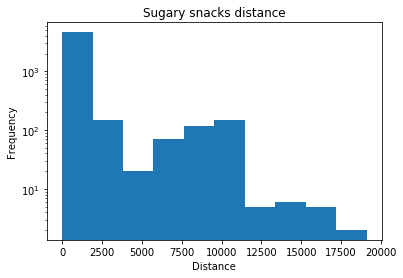

-------------
Meals


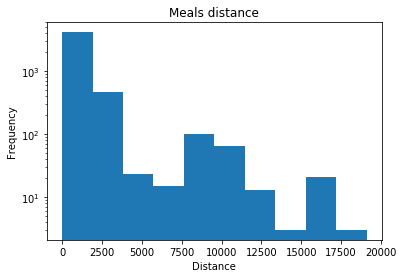

-------------
Dairies


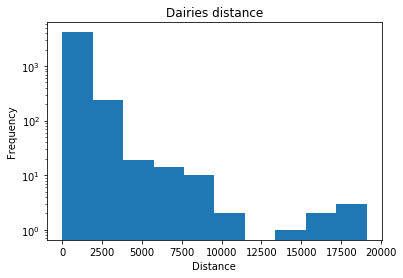

-------------
Beverages


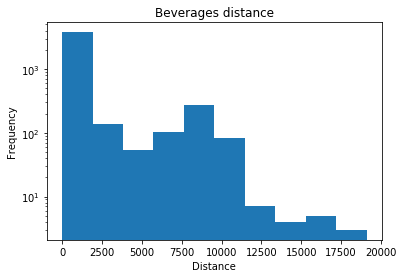

-------------
Meats


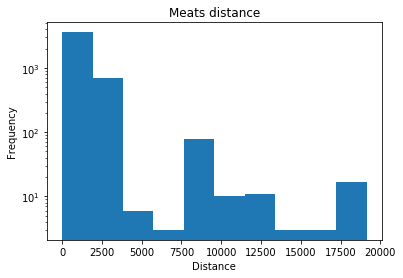

-------------
Fruits and vegetables based foods


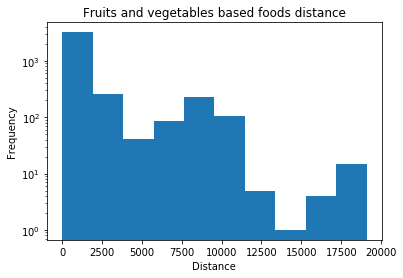

-------------
Fermented foods


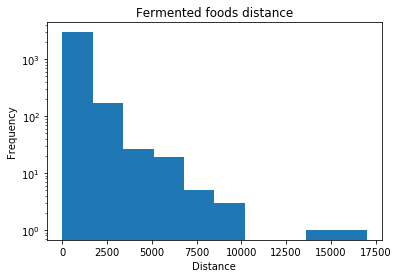

-------------
Fermented milk products


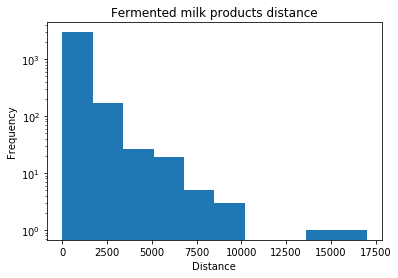

-------------
Cereals and potatoes


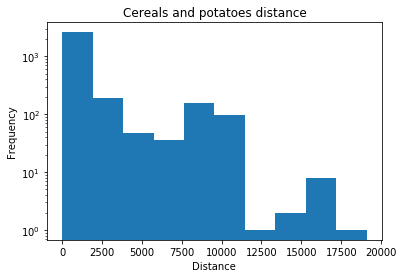

-------------
Biscuits and cakes


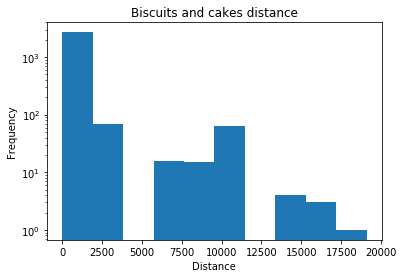

-------------
Prepared meats


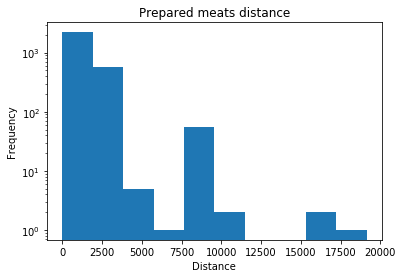

-------------
Spreads


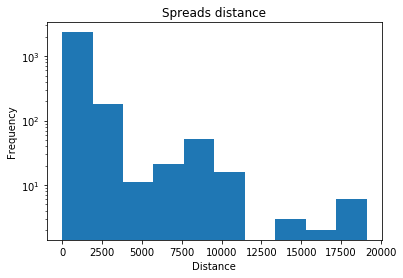

-------------
Frozen foods


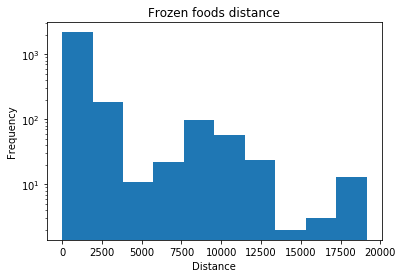

-------------


In [35]:
## lots of plots but its also all saved so we dont need to rerun them. 
for category in list(largest.index):
    # pick the category
    cat = merged[merged[0]==category]
    print(category)
    # get the distance as a float. 
    cat['distance'] = cat['distance'].apply(lambda x : float(x[:-2]))
    # plot 
    cat['distance'].plot.hist(bins=10,title=category+" distance",logy=True)
    plt.xlabel("Distance")
    plt.savefig("img/"+category+"_distance_sns.png",bbox_inches="tight")
    plt.show()
    print("-------------")
    

C:\Users\johan\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\johan\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


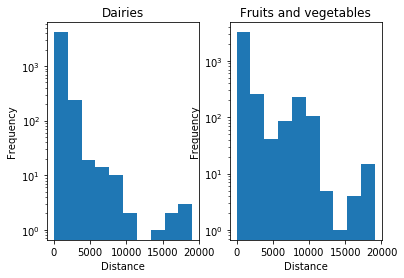

In [78]:
## here we compare two different categories side by side. 
plt.subplot(1, 2, 1)

## dairies here...
category = "Dairies"
cat1 = merged[merged[0]==category]
# get the distance as a float. 
cat1['distance'] = cat1['distance'].apply(lambda x : float(x[:-2]))
# plot 
cat1['distance'].plot.hist(bins=10,logy=True)
plt.xlabel("Distance")
# plt.title("Comparison of Dairies and Fruits and vegetables based foods distance")
plt.title("Dairies")

plt.subplot(1, 2, 2)

## here we show say. Fruits and vegetables based foods
category = "Fruits and vegetables based foods"
cat1 = merged[merged[0]==category]
# get the distance as a float. 
cat1['distance'] = cat1['distance'].apply(lambda x : float(x[:-2]))
# plot 
cat1['distance'].plot.hist(bins=10,logy=True)
plt.xlabel("Distance")
plt.title("Fruits and vegetables")

plt.savefig("img/compare_dairies_fruits_distance.png",bbox_inches='tight')
plt.show()

## Discussion 
<p> As we expect the further away the less product there are in each bin. However we note a few things</p>
<ul>
<li> For the category dairies, almost all products are producted locally</li>
<li> For Plant-based food, we can see there is a large number between 2500 and 1000km. This could be for products imported from Spain or Italy. </li>
<li> For a lot of category, we see that there is a peak of product that have a distance between 7500km and 10000km. Looking at a website compiling distance from France we see among others places like : Brazil, China, California, Guatemala, Mexico. Hence a lot of places where you can get tropical fruits or exotic products such as chocolate. </li>
</ul>